#### Work Log
- 6/18 - looked at the edit distance between the url_text, indicator, and title using NLTK, using extra trees to find they were all decent indicators with url_to_indicator being the best; this was using only around 35% of the data as I had dropped a lot of rows with missing values 
- 6/19 - was able to get a sample of 87% of the data to use for edit_distance analysis; the extra trees regressor had only 60ish% accuracy so I tried logistic regression and got accuracy up into the mid 80%s 
- 6/20 - worked on applying model to the subsets of data and had okay results, but they were not as good as the other data; also realized that the regressor probably works about the same as the classification model, the loss is just calculated differently
- 6/21 - worked in other notebook to save data encoding by requestID rather than indicator
- 6/24 - applied model to requestID labeled data and combined it with binary data showing which other types of data were present for each row; this seemed to work a bit better, but it is likely that some of that is just memorization of sites that come up a lot like google
- 6/25 - determined that there are a lot of duplicates from the way info was retrieved for websites like google docs or github and other websites with lots of sub pages, so I am working on incorporating the fetchpage data to hopefully get more insight on what is actually on those webpages to better distinguish between them
- 6/26 - goals: tidy up notebook and summarize findings so far, hopefully get the fetchpage data saved to a parquet file as it takes a very long time to load

In [1]:
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression

In [2]:
#old files from before new benign data was added
labels = pd.read_parquet('labels.gzip')
id_labels = pd.read_parquet('ID_labels.gzip')
usage_data_df = pd.read_parquet('usage_df.gzip')
main_df = pd.read_parquet('main_df.gzip')
country_rank_df = pd.read_parquet('country_rank_df.gzip')
domain_df = pd.read_parquet('owned_domain_df.gzip')
contr_subdom_df = pd.read_parquet('contributing_subdomain_df.gzip')
category_df = pd.read_parquet('category_df.gzip')
lev_df = pd.read_parquet('lev_df.gzip')
most_lev_df = pd.read_parquet('most_data_lev.gzip')
id_df = pd.read_parquet('ID_labelled_df.gzip')

In [3]:
main_df = pd.read_parquet('updated_main_df2.gzip')
main_df.head()

,requestID,status_code,adult_content,url_text,url_type,lang_encoding,lang_locale,links_in_count,description,online_since,title,med_load_time,load_speed_percentile,category_path,category,rank,indicator,success,unsafe
0,5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96,Success,no,google.com,canonical,None,en,2258679.0,Enables users to search the world's informatio...,1997-09-15,Google,1330.0,67.0,None,None,1.0,google.com,True,0.0
1,6036b07a-1e9d-4a8a-ae40-938504cfe696,Success,no,facebook.com,canonical,None,en,4532831.0,"A social utility that connects people, to keep...",1997-03-29,Facebook,3461.0,18.0,None,None,3.0,facebook.com,True,0.0
2,5b4446b2-c751-4315-a0d4-c86d8e1d1527,Success,no,youtube.com,canonical,None,en,1771102.0,YouTube is a way to get your videos to the peo...,2005-02-15,YouTube - Broadcast yourself,2852.0,26.0,None,None,2.0,youtube.com,True,0.0
3,f394a37c-3124-4ff8-8e02-2d93c1bbbc45,Success,no,twitter.com,canonical,None,en,3435448.0,Social networking and microblogging service ut...,2000-01-21,Twitter,1977.0,44.0,None,None,12.0,twitter.com,True,0.0
4,865bce56-288c-48e7-962e-e592f577dd31,Success,no,linkedin.com,canonical,None,en,1254390.0,A networking tool to find connections to recom...,2002-11-02,LinkedIn,2645.0,29.0,None,None,25.0,linkedin.com,True,0.0


In [3]:
bin_df = pd.read_parquet('ft_presence_df.gzip')
bin_df.head()

,requestID,status_code,adult_content,url_text,url_type,lang_encoding,lang_locale,links_in_count,owned_domains,description,...,category_path,category,subdoms,contr_subdom,rank,rank_by_country,use_stats,indicator,success,unsafe
0,5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96,1,1,1,1,0,1,1,0,1,...,0,0,1,1,1,1,1,1,1,1
1,6036b07a-1e9d-4a8a-ae40-938504cfe696,1,1,1,1,0,1,1,0,1,...,0,0,1,1,1,1,1,1,1,1
2,5b4446b2-c751-4315-a0d4-c86d8e1d1527,1,1,1,1,0,1,1,0,1,...,0,0,1,1,1,1,1,1,1,1
3,f394a37c-3124-4ff8-8e02-2d93c1bbbc45,1,1,1,1,0,1,1,0,1,...,0,0,1,1,1,1,1,1,1,1
4,865bce56-288c-48e7-962e-e592f577dd31,1,1,1,1,0,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1


In [5]:
main_df = pd.concat([main_df,bin_df.drop(columns = ['requestID','indicator','unsafe'])], axis=1)
main_df

,requestID,status_code,adult_content,url_text,url_type,lang_encoding,lang_locale,links_in_count,description,online_since,...,load_speed_percentile,category_data,category_path,category,subdoms,contr_subdom,rank,rank_by_country,use_stats,success
0,5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96,Success,no,google.com,canonical,None,en,2258679.0,Enables users to search the world's informatio...,1997-09-15,...,1,1,0,0,1,1,1,1,1,1
1,6036b07a-1e9d-4a8a-ae40-938504cfe696,Success,no,facebook.com,canonical,None,en,4532831.0,"A social utility that connects people, to keep...",1997-03-29,...,1,1,0,0,1,1,1,1,1,1
2,5b4446b2-c751-4315-a0d4-c86d8e1d1527,Success,no,youtube.com,canonical,None,en,1771102.0,YouTube is a way to get your videos to the peo...,2005-02-15,...,1,1,0,0,1,1,1,1,1,1
3,f394a37c-3124-4ff8-8e02-2d93c1bbbc45,Success,no,twitter.com,canonical,None,en,3435448.0,Social networking and microblogging service ut...,2000-01-21,...,1,1,0,0,1,1,1,1,1,1
4,865bce56-288c-48e7-962e-e592f577dd31,Success,no,linkedin.com,canonical,None,en,1254390.0,A networking tool to find connections to recom...,2002-11-02,...,1,1,0,0,1,1,1,1,1,1
5,1c03134a-114c-4d7d-b59c-45a731387ade,Success,no,microsoft.com,canonical,None,en,391426.0,"Main site for product information, support, an...",1991-05-02,...,1,1,0,0,1,1,1,1,1,1
6,e4352838-cd77-4a23-b76a-2f2aec88e8e5,Success,None,instagram.com,canonical,None,None,1351380.0,None,NaT,...,1,0,0,0,1,1,1,1,1,1
7,b781ef66-9501-4073-9821-f91034574d41,Success,no,wikipedia.org,canonical,None,en,1237609.0,A free encyclopedia built collaboratively usin...,2001-01-13,...,1,0,1,1,1,1,1,1,1,1
8,3b450de4-28ea-4a05-b00a-602e9003e1c2,Success,no,apple.com,canonical,None,en,296334.0,"Official site, with details of products and se...",NaT,...,1,1,0,0,1,1,1,1,1,1
9,de3b4afd-1998-401b-89c3-926bca9c9e4f,Success,no,google.com,canonical,None,en,2258679.0,Social network that aims to make sharing on th...,1997-09-15,...,1,1,0,0,1,1,1,1,1,1


In [17]:
main_df.T

,0,1,2,3,4,5,6,7,8,9,...,489926,489927,489928,489929,489930,489931,489932,489933,489934,489935
requestID,5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96,6036b07a-1e9d-4a8a-ae40-938504cfe696,5b4446b2-c751-4315-a0d4-c86d8e1d1527,f394a37c-3124-4ff8-8e02-2d93c1bbbc45,865bce56-288c-48e7-962e-e592f577dd31,1c03134a-114c-4d7d-b59c-45a731387ade,e4352838-cd77-4a23-b76a-2f2aec88e8e5,b781ef66-9501-4073-9821-f91034574d41,3b450de4-28ea-4a05-b00a-602e9003e1c2,de3b4afd-1998-401b-89c3-926bca9c9e4f,...,3262d8de-170c-4c51-824a-5c8a7da0b9ae,493f8a79-fc91-444e-8ef7-7e3ca02adcd6,4f291589-999a-4240-961f-fb72dbeb234e,7104f180-7c7f-41da-9d5a-8e82fc03eed0,17161d3a-b354-4d82-a57f-6240e7684a84,2dd3269f-6ccf-4f8a-870e-fe8c5aa26c4c,e074c482-c030-44f3-bf8e-10f799b0d9f9,1aac4138-51c7-4afe-90d4-992604eed9b6,e0c9a455-f5b5-4dcb-9ea6-01aff75236cc,312a1bfd-a1ae-4d01-8074-73240fac5006
status_code,Success,Success,Success,Success,Success,Success,Success,Success,Success,Success,...,Success,Success,Success,Success,Success,Success,Success,Success,Success,Success
adult_content,no,no,no,no,no,no,None,no,no,no,...,None,None,None,None,None,None,None,None,None,None
url_text,google.com,facebook.com,youtube.com,twitter.com,linkedin.com,microsoft.com,instagram.com,wikipedia.org,apple.com,google.com,...,spkasse-service-de.xyz,invoice9.online,directechs.us,connectedsoundsites.com,tesla-promo.netlify.com,securisation-donnee.ddns.net,partnersupport-lnstagram.com,yobemedia.com,manageprotections.gq,accedez-a-vos-fonds019.com
url_type,canonical,canonical,canonical,canonical,canonical,canonical,canonical,canonical,canonical,canonical,...,canonical,canonical,canonical,canonical,canonical,canonical,canonical,canonical,canonical,canonical
lang_encoding,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
lang_locale,en,en,en,en,en,en,None,en,en,en,...,None,None,None,None,None,None,None,None,None,None
links_in_count,2.25868e+06,4.53283e+06,1.7711e+06,3.43545e+06,1.25439e+06,391426,1.35138e+06,1.23761e+06,296334,2.25868e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
description,Enables users to search the world's informatio...,"A social utility that connects people, to keep...",YouTube is a way to get your videos to the peo...,Social networking and microblogging service ut...,A networking tool to find connections to recom...,"Main site for product information, support, an...",None,A free encyclopedia built collaboratively usin...,"Official site, with details of products and se...",Social network that aims to make sharing on th...,...,None,None,None,None,None,None,None,"Desarrollo web, Marketing Digital, Sistemas, B...",None,None
online_since,1997-09-15 00:00:00,1997-03-29 00:00:00,2005-02-15 00:00:00,2000-01-21 00:00:00,2002-11-02 00:00:00,1991-05-02 00:00:00,NaT,2001-01-13 00:00:00,NaT,1997-09-15 00:00:00,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [18]:
main_df['url_text'].drop_duplicates().reset_index(drop=True)

,url_text,url_text
0,google.com,1
1,facebook.com,1
2,youtube.com,1
3,twitter.com,1
4,linkedin.com,1
5,microsoft.com,1
6,instagram.com,1
7,wikipedia.org,1
8,apple.com,1
9,adobe.com,1


In [19]:
labels[labels['unsafe']==0].drop_duplicates()['indicator']

0                                                abola.pt
1                                             bodelen.com
2                                             pngtree.com
3                                                lenta.ru
4                                            facebook.com
5                                   termometropolitico.it
6                                               state.gov
7                                              blibli.com
8                                                naver.jp
9                                             samsung.com
10                                               v2ex.com
11                                         caijing.com.cn
12                                          office365.com
13                                           google.co.id
14                                           iqoption.com
15                                              nhk.or.jp
16                                           hespress.com
17            

In [19]:
main_df.dtypes

requestID                        object
status_code                      object
adult_content                    object
url_text                         object
url_type                         object
lang_encoding                    object
lang_locale                      object
links_in_count                  float64
description                      object
online_since             datetime64[ns]
title                            object
med_load_time                   float64
load_speed_percentile           float64
category_path                    object
category                         object
rank                            float64
indicator                        object
success                            bool
unsafe                          float64
status_code                       int64
adult_content                     int64
url_text                          int64
url_type                          int64
lang_encoding                     int64
lang_locale                       int64


In [4]:
#make sure there aren't duplicated requestIDs
id_df = main_df
id_df = id_df.dropna(thresh = 5)
print('total rows in id_df: '+ str(id_df.shape[0]))
print('duplicated requestIDs in id_df: ' + str(len(id_df['requestID'])-len(id_df['requestID'].drop_duplicates()))) # came out as 0 so no duplicates nice
#but without requestID
val = id_df.shape[0] - (id_df.drop(columns=['requestID']).drop_duplicates()).shape[0]
print('duplicated rows when requestID is dropped: ' + str(val)+ '; which is '+ str((val/id_df.shape[0])*100)+'% of rows') 

total rows in id_df: 462958
duplicated requestIDs in id_df: 0
duplicated rows when requestID is dropped: 121518; which is 26.248169380375757% of rows


In [14]:
main_df.dtypes

requestID                        object
status_code                      object
adult_content                   float64
url_text                         object
url_type                         object
lang_encoding                    object
lang_locale                      object
links_in_count                  float64
description                      object
online_since             datetime64[ns]
title                            object
med_load_time                    object
load_speed_percentile           float64
category_path                    object
category                         object
rank                            float64
indicator                        object
success                            bool
dtype: object

In [8]:
#looking at duplicate indicators in main_df -> google.com comes up 372x 
main_df['indicator'].value_counts().head(50)

google.com             390
cisco.com              250
ticketmaster.com       119
roblox.com             119
amazon.fr              119
mit.edu                119
live.com               119
ibm.com                119
caijing.com.cn         119
mercari.com            119
springer.com           119
slack.com              119
outbrain.com           119
rus.ec                 119
studfiles.net          119
openload.co            119
independent.co.uk      119
ca.gov                 119
livejasmin.com         119
lifewire.com           119
zoom.us                119
biobiochile.cl         118
utorrent.com           118
washingtonpost.com     118
southwest.com          118
gfycat.com             118
socialblade.com        118
primevideo.com         118
gismeteo.ru            118
gsmarena.com           118
zhanqi.tv              118
yaplakal.com           118
kooora.com             118
familydoctor.com.cn    118
adp.com                118
tsa-algerie.com        118
exoclick.com           118
w

In [10]:
#not using
#main_df.groupby(['indicator']).first()
temp = main_df
temp['na_count'] = main_df.shape[1] - main_df.count(axis=1)
cols = ['lang_encoding','category','category_path','online_since','lang_locale','adult_content','description','url_type']
temp = temp.drop(columns=cols).dropna(thresh=3).sort_values(['url_text','indicator','na_count'])
#temp = temp.merge(id_labels)
temp = temp.drop(columns=['requestID']).drop_duplicates().merge(main_df[['requestID']],left_index = True,right_index=True)
#temp[temp['url_text']=='google.com']
temp['requestID'].value_counts()
#funcs = {'re}
#temp.groupby(['indicator'])['na_count'].min()

2d678c58-9d11-4b2e-819f-0de2576f0db2    1
f9b30433-4212-408f-a9de-48ba6fe7ca78    1
dd5503a1-37ee-4993-81a5-ba8b310be5d1    1
62da1534-7cd2-4bc7-a195-8c18c1213f54    1
10b250e2-8a44-4130-ac3f-16f740cdc03c    1
a82c9b12-7552-4788-8bba-8d195682d17f    1
8e50db8c-8f51-4661-99b7-d8a2dafa7ccb    1
11eec68e-036b-4bf7-ae88-72b7a05c61b3    1
a7df45f7-4c94-4cdc-909c-97791ffafc28    1
4701fb3e-5a99-4425-b152-592605f4e374    1
7df04a08-e2d9-450e-b65f-b702c025c159    1
6c824b44-0622-419e-b37d-165edde2490d    1
765c403a-92a8-4f36-8caa-eb7754a7dbd5    1
19a558ff-7d14-4882-8a97-5b3e99890138    1
04ab9901-0187-4a87-81a0-2ac138012dbb    1
68df1fb0-3bbd-4dfd-a33d-67df1821ae07    1
df0677de-7cc0-448d-aa11-e4f7c424b421    1
40b059cc-2bee-44f4-9def-08a7f71594ac    1
a0ba4591-1bcc-48ae-bfa0-7b7102908eb8    1
42dfca60-8eb0-42f0-8a1d-a691b53feaf0    1
e64d2633-7d3d-43e2-bd31-6526435a1b55    1
3f8e5418-65b0-4ef9-9269-70ff7f395b20    1
1c4953bd-da3e-4093-b4a1-c18cb2447a2c    1
642499cb-83c4-478a-b49b-251e96018f

In [8]:
temp['indicator'].value_counts()

google.com                                                      390
cisco.com                                                       251
amazon.fr                                                       121
ticketmaster.com                                                121
independent.co.uk                                               121
mit.edu                                                         121
lifewire.com                                                    121
zhihu.com                                                       120
douyu.com                                                       120
ibm.com                                                         120
hupu.com                                                        120
sohu.com                                                        120
wiktionary.org                                                  120
live.com                                                        120
getpocket.com                                   

In [20]:
url_counts = main_df['url_text'].value_counts()
url_counts.loc[url_counts <= 10]
v_lst = []
count_lst = []
for v in url_counts.drop_duplicates():
    v_lst.append(v)
    count_lst.append(len((url_counts.loc[url_counts <= v]).drop_duplicates()))

plt.scatter(v_lst,count_lst, s = 2)
plt.xlabel('Max # of Dups per URL') 
plt.ylabel('# of Sites')

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [19]:
len(url_counts.loc[url_counts <= 200])

61203

Text(0,0.5,'# of Sites')

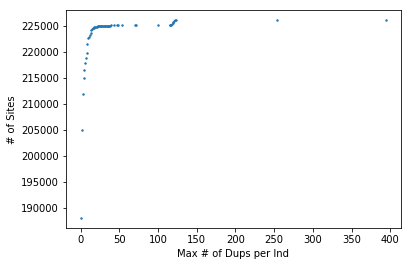

In [5]:
ind_counts =main_df['indicator'].value_counts()

v_lst = []
count_lst = []
for v in ind_counts.drop_duplicates():
    v_lst.append(v)
    count_lst.append(len((ind_counts.loc[ind_counts <= v])))

plt.scatter(v_lst,count_lst, s = 2)
plt.xlabel('Max # of Dups per Ind') 
plt.ylabel('# of Sites')

In [7]:
len(ind_counts.loc[ind_counts <= 15])

223515

In [8]:
main_df.columns = list(main_df.columns[:19])+['status_bin','adult_bin','url_text_bin','url_type_bin','encoding_bin', 'locale_bin','links_bin','owned_bin','description_bin','online_bin','title_bin','med_bin','perc_bin', 'catd_bin', 'catp_bin', 'cat_bin', 'subdom_bin', 'contr_bin', 'rank_bin', 'country_rank_bin', 'use_bin', 'success_bin']

In [9]:
#main_df = pd.read_parquet('main_df.gzip')
main_df.dtypes

requestID                        object
status_code                      object
adult_content                    object
url_text                         object
url_type                         object
lang_encoding                    object
lang_locale                      object
links_in_count                  float64
description                      object
online_since             datetime64[ns]
title                            object
med_load_time                   float64
load_speed_percentile           float64
category_path                    object
category                         object
rank                            float64
indicator                        object
success                            bool
unsafe                          float64
status_bin                        int64
adult_bin                         int64
url_text_bin                      int64
url_type_bin                      int64
encoding_bin                      int64
locale_bin                        int64


#### main_df columns
- requestID-----------------                        string of format: x{8}-x{4}-x{4}-x{4}-x{12}
- status_code---------------         string: 'Success','Error', or None - does not neccesarily match the success column 
- adult_content-------------                   float64: 1 for yes, 0 for no, Nan if nothing reported
- url_text------------------                         string x+\.x+ ie urls
- url_type------------------                         None or 'canonical'
- lang_encoding-------------                    string of format: x+(-|_)?x* or None
- lang_locale---------------                      string of format: xx-?(XX)? or xx-unknown or None
- links_in_count------------   float64: NaN or number (max so far is around 6.2 million, min is 1 so NaN actually might mean 0)
- description---------------                      string or None
- online_since--------------             datetime64[ns] : YYYY-MM-DD or NaT
- title-------------------------                            string of format: url/ or text 
- med_load_time -------------- object: number or None -- SHOULD BE float with NaNs for missing vals
- load_speed_percentile-----           float64 between 0.0 and 100.0 or NaN
- category_path-------------                    string of format Top/x+(/x+)* or None
- category------------------                         string of format x+/x+ or None
- rank----------------------                            float64 (actually are integers) between 1 and 19.9 million or NaN - only a small amount of rows actually have this value
- indicator-----------------                        string most often matches url 
- success-------------------                            bool
- unsafe--------------------                          float64: 0 for safe, 1 for unsafe

In [32]:
#Counting the number of missing values in each column. Prints in decreasing order of missing values. 
#category_path, and category are missing for most of the data so this info will be dropped, those that do have it can be found
    #in the category dataframe, category_df
max_rows = main_df.shape[0]
print(max_rows)
missing_vals = dict(main_df.isna().sum())
sorted(missing_vals.items(), key=lambda kv: kv[1], reverse = True)

489936


[('category_path', 423558),
 ('category', 423558),
 ('online_since', 392256),
 ('lang_encoding', 384155),
 ('description', 358086),
 ('lang_locale', 350891),
 ('adult_content', 340704),
 ('med_load_time', 278887),
 ('load_speed_percentile', 278887),
 ('rank', 246824),
 ('links_in_count', 183720),
 ('url_text', 33092),
 ('url_type', 33092),
 ('title', 33092),
 ('requestID', 26978),
 ('status_code', 26814),
 ('indicator', 20784),
 ('success', 0),
 ('unsafe', 0)]

In [10]:
#exploartion to determine what dropped columns would give me a decent sample
# -- any results commented in the code are using data up through 6/18
#main_df = main_df.merge(labels, how = 'left')
print(main_df.shape[0])
max_rows = main_df.shape[0]

cols = ['category','category_path']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print(r)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['category','category_path','lang_encoding']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['lang_encoding']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['lang_encoding','online_since']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['online_since']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['category','category_path','online_since']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['lang_encoding','category','category_path','online_since']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print() #result -> rows: 47396 -> 15.30804386092405%; unsafe: 2879.0 -> 6.074352266014009%

cols = ['lang_encoding','category','category_path','online_since','lang_locale']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print() #result -> rows: 54860 -> 17.718779774881707%; unsafe: 6055.0 -> 11.037185563251914%

cols = ['lang_encoding','category','category_path','online_since','lang_locale','adult_content']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print() #result -> rows: 68496 -> 22.122959158955478%; unsafe: 7277.0 -> 10.62397804251343%

cols = ['lang_encoding','category','category_path','online_since','lang_locale','adult_content','description','url_type']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print() #result -> rows: 110827 -> 35.7951003665843%; unsafe: 22871.0 -> 20.636667959973654%

#decided to take rank out as well to avoid an explicit circle 
cols = ['lang_encoding','category','category_path','online_since','lang_locale','adult_content','description','url_type','rank']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +' -> '+str((r/max_rows)*100)+'%; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()


489936
['category', 'category_path']
44240
rows: 44240 -> 9.0297508245975%; unsafe: 20471.0 -> 46.27260397830018%

['category', 'category_path', 'lang_encoding']
rows: 67772 -> 13.83282714476993%; unsafe: 23237.0 -> 34.2870211886915%

['lang_encoding']
rows: 34723 -> 7.0872522125338815%; unsafe: 12990.0 -> 37.410362007891024%

['lang_encoding', 'online_since']
rows: 47614 -> 9.718412200777244%; unsafe: 17580.0 -> 36.92191372285462%

['online_since']
rows: 37253 -> 7.603646190522843%; unsafe: 16063.0 -> 43.11867500603978%

['category', 'category_path', 'online_since']
rows: 64120 -> 13.087423663498907%; unsafe: 28191.0 -> 43.966001247660635%

['lang_encoding', 'category', 'category_path', 'online_since']
rows: 91419 -> 18.65937591848731%; unsafe: 31271.0 -> 34.20623721545849%

['lang_encoding', 'category', 'category_path', 'online_since', 'lang_locale']
rows: 102587 -> 20.93885732013977%; unsafe: 36784.0 -> 35.8563950598029%

['lang_encoding', 'category', 'category_path', 'online_since'

In [6]:
main_df=main_df.drop(columns=['category','category_path','url_type'])

In [46]:
main_df.dropna(subset=['url_text','title','indicator']).reset_index(drop=True).loc[:20,['indicator','url_text','title']]

,indicator,url_text,title
0,google.com,google.com,Google
1,facebook.com,facebook.com,Facebook
2,youtube.com,youtube.com,YouTube - Broadcast yourself
3,twitter.com,twitter.com,Twitter
4,linkedin.com,linkedin.com,LinkedIn
5,microsoft.com,microsoft.com,Microsoft Corporation
6,instagram.com,instagram.com,instagram.com/
7,wikipedia.org,wikipedia.org,Wikipedia
8,apple.com,apple.com,"Apple Computer, Inc."
9,plus.google.com,google.com,Google+


In [7]:
# -- don't need to run unless updating the lev_df.gzip file --
#finding edit_distance between url, indicator, and title for last sample taken above
temp = main_df.dropna(subset=['url_text','title','indicator']).reset_index(drop=True)
#temp['title'] = temp['title'].apply(str.lower)
url_to_title = []
for i in range(len(temp['unsafe'])):
    url_to_title.append(nltk.edit_distance(temp['url_text'][i],temp['title'][i]))
url_to_title
temp['url_to_title'] = url_to_title
url_to_ind = []
for i in range(len(temp['unsafe'])):
    url_to_ind.append(nltk.edit_distance(temp['url_text'][i],temp['indicator'][i]))
temp['url_to_ind'] = url_to_ind
title_to_ind = []
for i in range(len(temp['unsafe'])):
    title_to_ind.append(nltk.edit_distance(temp['title'][i],temp['indicator'][i]))
temp['title_to_ind'] = title_to_ind

# save to parquet file - this df gets loaded in the loading block near the top
lev_df = temp.drop(columns=['success','status_code'])
#lev_df.to_parquet('lev_df.gzip',compression = 'gzip')
lev_df[['indicator','url_text','title','url_to_title', 'url_to_ind','title_to_ind']]

KeyError: ('indicator', 'url_text', 'title', 'url_to_title', 'url_to_ind', 'title_to_ind')

In [24]:

lev_df[['indicator','url_text','title','url_to_title', 'url_to_ind','title_to_ind']].sample(100)


,indicator,url_text,title,url_to_title,url_to_ind,title_to_ind
401152,https://counter-strike.soft32.com/free-downloa...,soft32.com,Soft32.com,1,61,62
410929,securemail.incomm.com.cert-ssl.com,cert-ssl.com,securemail.incomm.com.cert-ssl.com/,23,22,1
174608,americanas.com.br,americanas.com.br,Americanas.com,4,0,4
413121,bicentenariobu.com,bicentenariobu.com,bicentenariobu.com/,1,0,1
314580,google.ro,google.ro,Google,4,0,4
75811,goodvibes.com,goodvibes.com,Good Vibrations,9,0,9
2462,rwu.edu,rwu.edu,Roger Williams University,23,0,23
341422,getawesome1.com,getawesome1.com,getawesome1.com/,1,0,1
120071,cam-itour.info,cam-itour.info,cam-itour.info/,1,0,1
118551,http://senboutiquespa.com/l5oBTin,senboutiquespa.com,senboutiquespa.com/l5oBTin,8,15,7


In [68]:
lev_df = pd.read_parquet('lev_df.gzip')
#lev_df = lev_df.drop(columns=['status_code'])
#lev_df = lev_df.groupby(['indicator'],as_index=False).first()
lev_df

,requestID,adult_content,lang_encoding,lang_locale,links_in_count,description,online_since,med_load_time,load_speed_percentile,rank,...,cat_bin,subdom_bin,contr_bin,rank_bin,country_rank_bin,use_bin,success_bin,url_to_title,url_to_ind,title_to_ind
0,5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96,no,None,en,2258679.0,Enables users to search the world's informatio...,1997-09-15,1330.0,67.0,1.0,...,0,1,1,1,1,1,1,4,0,4
1,6036b07a-1e9d-4a8a-ae40-938504cfe696,no,None,en,4532831.0,"A social utility that connects people, to keep...",1997-03-29,3461.0,18.0,3.0,...,0,1,1,1,1,1,1,4,0,4
2,5b4446b2-c751-4315-a0d4-c86d8e1d1527,no,None,en,1771102.0,YouTube is a way to get your videos to the peo...,2005-02-15,2852.0,26.0,2.0,...,0,1,1,1,1,1,1,19,0,19
3,f394a37c-3124-4ff8-8e02-2d93c1bbbc45,no,None,en,3435448.0,Social networking and microblogging service ut...,2000-01-21,1977.0,44.0,12.0,...,0,1,1,1,1,1,1,4,0,4
4,865bce56-288c-48e7-962e-e592f577dd31,no,None,en,1254390.0,A networking tool to find connections to recom...,2002-11-02,2645.0,29.0,25.0,...,0,1,1,1,1,1,1,4,0,4
5,1c03134a-114c-4d7d-b59c-45a731387ade,no,None,en,391426.0,"Main site for product information, support, an...",1991-05-02,2408.0,34.0,35.0,...,0,1,1,1,1,1,1,10,0,10
6,e4352838-cd77-4a23-b76a-2f2aec88e8e5,None,None,None,1351380.0,None,NaT,1670.0,55.0,16.0,...,0,1,1,1,1,1,1,1,0,1
7,b781ef66-9501-4073-9821-f91034574d41,no,None,en,1237609.0,A free encyclopedia built collaboratively usin...,2001-01-13,938.0,82.0,5.0,...,1,1,1,1,1,1,1,4,0,4
8,3b450de4-28ea-4a05-b00a-602e9003e1c2,no,None,en,296334.0,"Official site, with details of products and se...",NaT,1997.0,44.0,58.0,...,0,1,1,1,1,1,1,12,0,12
9,de3b4afd-1998-401b-89c3-926bca9c9e4f,no,None,en,2258679.0,Social network that aims to make sharing on th...,1997-09-15,1330.0,67.0,1.0,...,0,1,1,1,1,1,1,4,5,9


In [42]:
lev_df.to_parquet('lev_df.gzip',compression = 'gzip')

In [60]:
hold = lev_df.copy()

In [48]:
lev_df.dtypes#loc[1,:].T

requestID                        object
adult_content                    object
lang_encoding                    object
lang_locale                      object
links_in_count                  float64
description                      object
online_since             datetime64[ns]
med_load_time                   float64
load_speed_percentile           float64
rank                            float64
indicator                        object
unsafe                          float64
status_bin                        int64
adult_bin                         int64
url_text_bin                      int64
url_type_bin                      int64
encoding_bin                      int64
locale_bin                        int64
links_bin                         int64
owned_bin                         int64
description_bin                   int64
online_bin                        int64
title_bin                         int64
med_bin                           int64
perc_bin                          int64


In [15]:
print(bin_df.shape)
sums = bin_df.sum(axis=0)

(489936, 25)


In [17]:
sums

status_code              463122
adult_content            149232
url_text                 456844
url_type                 456844
lang_encoding            105781
lang_locale              139045
links_in_count           306216
owned_domains             36784
description              131850
online_since              97680
title                    456844
med_load_time            211049
load_speed_percentile    211049
category_data             38720
category_path             66378
category                  66378
subdoms                  456844
contr_subdom             167792
rank                     243112
rank_by_country          195894
use_stats                229196
indicator                469152
success                  489936
unsafe                   489936
dtype: int64

In [16]:
list(zip(lev_df['requestID'], bin_df['requestID'], range(0,len(lev_df['requestID']))))

[('5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96',
  '5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96',
  0),
 ('6036b07a-1e9d-4a8a-ae40-938504cfe696',
  '6036b07a-1e9d-4a8a-ae40-938504cfe696',
  1),
 ('5b4446b2-c751-4315-a0d4-c86d8e1d1527',
  '5b4446b2-c751-4315-a0d4-c86d8e1d1527',
  2),
 ('f394a37c-3124-4ff8-8e02-2d93c1bbbc45',
  'f394a37c-3124-4ff8-8e02-2d93c1bbbc45',
  3),
 ('865bce56-288c-48e7-962e-e592f577dd31',
  '865bce56-288c-48e7-962e-e592f577dd31',
  4),
 ('1c03134a-114c-4d7d-b59c-45a731387ade',
  '1c03134a-114c-4d7d-b59c-45a731387ade',
  5),
 ('e4352838-cd77-4a23-b76a-2f2aec88e8e5',
  'e4352838-cd77-4a23-b76a-2f2aec88e8e5',
  6),
 ('b781ef66-9501-4073-9821-f91034574d41',
  'b781ef66-9501-4073-9821-f91034574d41',
  7),
 ('3b450de4-28ea-4a05-b00a-602e9003e1c2',
  '3b450de4-28ea-4a05-b00a-602e9003e1c2',
  8),
 ('de3b4afd-1998-401b-89c3-926bca9c9e4f',
  'de3b4afd-1998-401b-89c3-926bca9c9e4f',
  9),
 ('afefc91f-9bdc-4040-89b3-bd28d0ee6301',
  'afefc91f-9bdc-4040-89b3-bd28d0ee6301',
  10),
 ('b4efed

In [75]:
lev_df = lev_df.drop(columns=['requestID','rank','adult_content','lang_encoding','lang_locale','description','online_since','indicator'])#[['requestID','url_to_title','url_to_ind','title_to_ind','rank','links_in_count','load_speed_percentile', 'med_load_time','unsafe']]
#lev_df = lev_df.drop(columns=['rank'])
lev_df = lev_df.dropna()
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(data = scaler.fit_transform(lev_df), columns = lev_df.columns)
#X['requestID'] = lev_df['requestID']
#X = X.drop_duplicates()
X1 = X[X['unsafe']==1].sample(frac=1)
X0 = X[X['unsafe']==0].sample(frac=1)
print(len(X1))
print(len(X0))
if(X0.shape[0] < X1.shape[0]):
    X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
    #X1 = X1
else: 
    X0 = X0.reset_index(drop=True).loc[:(X1.shape[0]),:]
    #X0 = X0.reset_index(drop=True)
temp_df = pd.concat([X0,X1]).sample(frac=1).reset_index(drop=True)
#temp_df = temp_df.merge(bin_df.drop(columns=['rank', 'links_in_count','load_speed_percentile', 'med_load_time','indicator','success','unsafe','category','category_path','url_text','url_type','title','status_code'][:1050]), how='inner')
X = temp_df.drop(columns=['unsafe'])
Y = temp_df['unsafe']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.60, test_size=0.40, random_state=12)

90692
119752


w/o rank
0.979436006284974
('links_in_count', 0.36946939914917853)
('med_load_time', 0.11173872458556437)
('load_speed_percentile', 0.07765467523487334)
('status_bin', 0.0)
('adult_bin', 0.014826346876313536)
('url_text_bin', 0.0)
('url_type_bin', 0.0)
('encoding_bin', 0.023249004255523356)
('locale_bin', 0.009344763797140014)
('links_bin', 0.0)
('owned_bin', 0.007579100613404666)
('description_bin', 0.019065240479778367)
('online_bin', 0.012017928091266313)
('title_bin', 0.0)
('med_bin', 0.0)
('perc_bin', 0.0)
('catd_bin', 0.006658113878332972)
('catp_bin', 0.005237568393641687)
('cat_bin', 0.00471469790775761)
('subdom_bin', 0.0)
('contr_bin', 0.055731807859384225)
('rank_bin', 0.005456057300427428)
('country_rank_bin', 0.02537359697407563)
('use_bin', 0.010902094729310493)
('success_bin', 0.0)
('url_to_title', 0.06556089425506557)
('url_to_ind', 0.1053024352296599)
('title_to_ind', 0.07011755038930181)
             precision    recall  f1-score   support

        0.0       0.97     

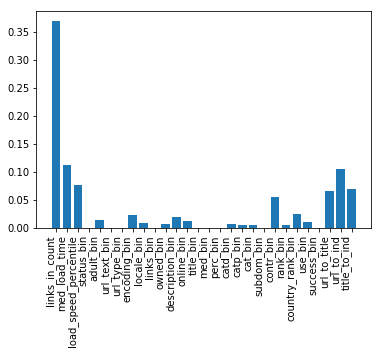

15


In [76]:
from sklearn.ensemble import RandomForestClassifier
def rfc (lst, train_prop):
    forest = RandomForestClassifier(n_estimators=15,min_samples_split = 2,random_state=10)
    forest.fit(X_train, Y_train)
    print(forest.score(X_test,Y_test))
    print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
    print(classification_report(Y_test,forest.predict(X_test)))
    plt.bar(range(len(X.columns)), forest.feature_importances_)
    plt.xticks(range(0,len(X.columns)), X.columns)
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
    plt.show()
    print(len(forest.estimators_))
    
    
train_prop = .6
print('w/o rank')
rfc(['unsafe','requestID','indicator'],train_prop)


w/o rank
0.9613804890150784
('med_load_time', 0.27410270016032984)
('load_speed_percentile', 0.13766891806095255)
('status_bin', 0.0)
('adult_bin', 0.013927966254539468)
('url_text_bin', 0.0)
('url_type_bin', 0.0)
('encoding_bin', 0.033415824429768246)
('locale_bin', 0.009877570568754856)
('links_bin', 0.0)
('owned_bin', 0.012410993575386917)
('description_bin', 0.017288739950380626)
('online_bin', 0.013717356245836)
('title_bin', 0.0)
('med_bin', 0.0)
('perc_bin', 0.0)
('catd_bin', 0.008586380483295387)
('catp_bin', 0.0032247031998172684)
('cat_bin', 0.004735736485751704)
('subdom_bin', 0.0)
('contr_bin', 0.0860918976198155)
('rank_bin', 0.0037756382980740715)
('country_rank_bin', 0.05157848132960799)
('use_bin', 0.009838649029048418)
('success_bin', 0.0)
('url_to_title', 0.09108368162886753)
('url_to_ind', 0.15452233551288455)
('title_to_ind', 0.0741524271668891)
             precision    recall  f1-score   support

        0.0       0.94      0.98      0.96     36428
        1.0    

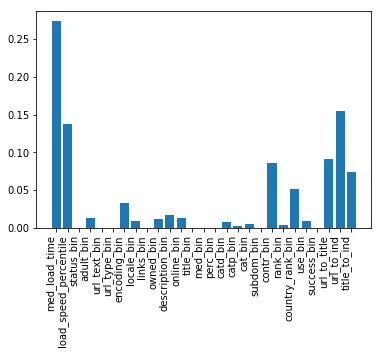

15


In [79]:
from sklearn.ensemble import RandomForestClassifier
def rfc (lst, train_prop):
    forest = RandomForestClassifier(n_estimators=15,min_samples_split = 2,random_state=10)
    forest.fit(X_train, Y_train)
    print(forest.score(X_test,Y_test))
    print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
    print(classification_report(Y_test,forest.predict(X_test)))
    plt.bar(range(len(X.columns)), forest.feature_importances_)
    plt.xticks(range(0,len(X.columns)), X.columns)
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
    plt.show()
    print(len(forest.estimators_))
    
#X_train = X_train.drop(columns=['links_in_count'])
#X_test = X_test.drop(columns=['links_in_count'])
#X = X.drop(columns=['links_in_count'])
train_prop = .6
print('w/o rank')
rfc(['unsafe','requestID','indicator'],train_prop)


# Comparison of ExtraTrees vs RandomForests on this subset of data
Note: all of these models currently use 5% of the data to train and 95% to test
### ExtraTreesClassifier on different feature subsets of data (37% of total data)

### RandomForestClassifier (37% of total data)
Might be slightly better when more features are given

w/o rank
0.9839587706274852
('url_to_title', 0.010107978781744973)
('url_to_ind', 0.034404157418338556)
('title_to_ind', 0.008947931312687611)
('rank', 0.8157826780667273)
('links_in_count', 0.10108613852382416)
('load_speed_percentile', 0.013029651510455034)
('med_load_time', 0.01664146438622254)
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98     29369
        1.0       0.98      0.98      0.98     29230

avg / total       0.98      0.98      0.98     58599



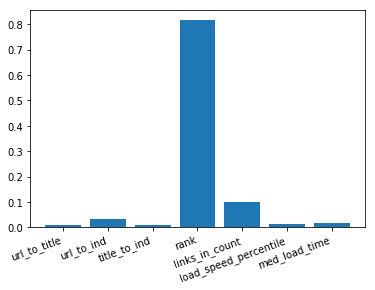

10


In [68]:
from sklearn.ensemble import RandomForestClassifier
def rfc (lst, train_prop):
    #X = lev_df.drop(columns=lst)
    #plt.figure(figsize=(20,20))
    #Y = lev_df[['unsafe']]
    #X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size= train_prop, test_size= 1-train_prop,random_state = 10)
    forest = RandomForestClassifier(min_samples_split = 3,random_state=12)
    forest.fit(X_train, Y_train)
    print(forest.score(X_test,Y_test))
    print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
    print(classification_report(Y_test,forest.predict(X_test)))
    plt.bar(range(7), forest.feature_importances_)
    plt.xticks(range(0,7), X.columns)
    plt.setp(plt.gca().get_xticklabels(), rotation=20, horizontalalignment='right')
    plt.show()
    print(len(forest.estimators_))
    
    
train_prop = .6
print('w/o rank')
rfc(['unsafe','requestID','indicator'],train_prop)




#plt.bar(range(len(word_dict)), word_dict.values(), align='center')




w/o rank
0.9614669192307036
('url_to_title', 0.06148271134157024)
('url_to_ind', 0.09133176351290961)
('title_to_ind', 0.05371049559101608)
('links_in_count', 0.504221794603901)
('load_speed_percentile', 0.10523643607368993)
('med_load_time', 0.18401679887691305)
             precision    recall  f1-score   support

        0.0       0.94      0.99      0.96     29369
        1.0       0.98      0.94      0.96     29230

avg / total       0.96      0.96      0.96     58599



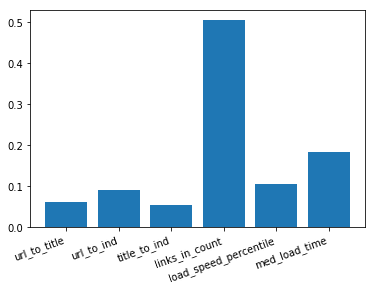

10


In [69]:
from sklearn.ensemble import RandomForestClassifier
def rfc (lst, train_prop):
    #X = lev_df.drop(columns=lst)
    #plt.figure(figsize=(20,20))
    #Y = lev_df[['unsafe']]
    #X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size= train_prop, test_size= 1-train_prop,random_state = 10)
    X_train2 = X_train.drop(columns=['rank'])
    X_test2 = X_test.drop(columns=['rank'])
    forest = RandomForestClassifier(min_samples_split = 3, random_state=12)
    forest.fit(X_train2, Y_train)
    print(forest.score(X_test2,Y_test))
    print(*(list(zip(X_train2.columns,forest.feature_importances_))), sep = '\n')
    print(classification_report(Y_test,forest.predict(X_test2)))
    plt.bar(range(6), forest.feature_importances_)
    plt.xticks(range(0,6), X_train2.columns)
    plt.setp(plt.gca().get_xticklabels(), rotation=20, horizontalalignment='right')
    plt.show()
    print(len(forest.estimators_))
    
    
train_prop = .6
print('w/o rank')
rfc(['unsafe','requestID','indicator'],train_prop)



#plt.bar(range(len(word_dict)), word_dict.values(), align='center')




w/o rank
0.914571921022543
('url_to_title', 0.05844874520152199)
('url_to_ind', 0.13660559462630803)
('title_to_ind', 0.06560040991051684)
('load_speed_percentile', 0.14776040902757878)
('med_load_time', 0.5915848412340743)
             precision    recall  f1-score   support

        0.0       0.87      0.97      0.92     29369
        1.0       0.97      0.86      0.91     29230

avg / total       0.92      0.91      0.91     58599



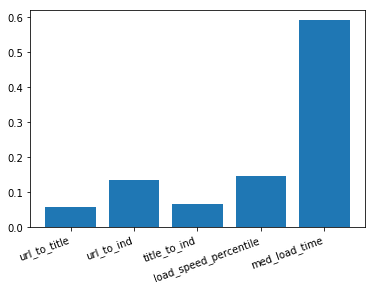

10


In [70]:
from sklearn.ensemble import RandomForestClassifier
def rfc (lst, train_prop):
    #X = lev_df.drop(columns=lst)
    #plt.figure(figsize=(20,20))
    #Y = lev_df[['unsafe']]
    #X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size= train_prop, test_size= 1-train_prop,random_state = 10)
    X_train2 = X_train.drop(columns=['rank','links_in_count'])
    X_test2 = X_test.drop(columns=['rank','links_in_count'])
    forest = RandomForestClassifier(min_samples_split = 3,random_state=12)
    forest.fit(X_train2, Y_train)
    print(forest.score(X_test2,Y_test))
    print(*(list(zip(X_train2.columns,forest.feature_importances_))), sep = '\n')
    print(classification_report(Y_test,forest.predict(X_test2)))
    plt.bar(range(5), forest.feature_importances_)
    plt.xticks(range(0,5), X_train2.columns)
    plt.setp(plt.gca().get_xticklabels(), rotation=20, horizontalalignment='right')
    plt.show()
    print(len(forest.estimators_))
    
    
train_prop = .6
print('w/o rank')
rfc(['unsafe','requestID','indicator'],train_prop)




#plt.bar(range(len(word_dict)), word_dict.values(), align='center')




In [100]:
from sklearn.ensemble import ExtraTreesClassifier
train_prop=.6
def etc (lst, train_prop):
   # X = X#lev_df.drop(columns=lst)
    #Y = Ylev_df[['unsafe']]
    #X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size= train_prop, test_size= 1-train_prop,random_state = 10)
    forest = ExtraTreesClassifier(min_samples_split = 3)
    forest.fit(X_train, Y_train)
    print(forest.score(X_test,Y_test))
    print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
    print(classification_report(Y_test,forest.predict(X_test)))
    print()
    

train_prop = .4
print('w/o url_to_ind')
etc(['unsafe','url_to_ind'],train_prop)

print('w/o url_to_ind or title_to_ind')
etc(['unsafe','url_to_ind','title_to_ind'],train_prop)

print('w/ url_to_ind')
etc(['unsafe'],train_prop)


w/o url_to_ind
0.8105218135158255
('url_to_title', 0.0591507004533627)
('url_to_ind', 0.046594548400607144)
('title_to_ind', 0.05810703379110377)
('links_in_count', 0.5676182833519717)
('load_speed_percentile', 0.11361054773942367)
('med_load_time', 0.15491888626353098)
             precision    recall  f1-score   support

        0.0       0.82      0.81      0.82      1200
        1.0       0.80      0.81      0.81      1138

avg / total       0.81      0.81      0.81      2338


w/o url_to_ind or title_to_ind
0.7895637296834902
('url_to_title', 0.06162913685225534)
('url_to_ind', 0.04286927807176023)
('title_to_ind', 0.05876851392466459)
('links_in_count', 0.541310036315646)
('load_speed_percentile', 0.1333765764995771)
('med_load_time', 0.16204645833609665)
             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80      1200
        1.0       0.79      0.77      0.78      1138

avg / total       0.79      0.79      0.79      2338


w/ url_to_in

### ExtraTreesClassifier vs ExtraTreesRegressor on 87% of data
This next block suggests that the model can usually guess correctly in terms of classfication, but often is not totally sure. The Y values I'm passing into the regressor are only 0s and 1s so the model is being compared to definitive classifications which results in a seemingly lower accuracy even when the top and bottem models return nearly the same percentages when using predict_proba() on the top. 

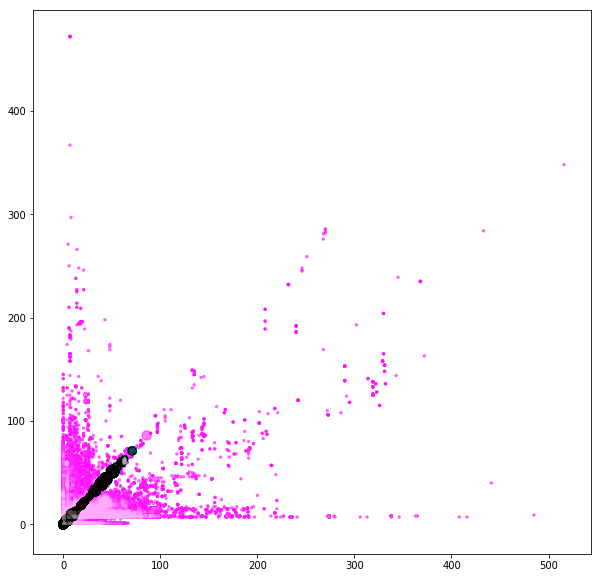

In [154]:
plt.figure(figsize=(10,10))
plt.scatter(temp['url_to_title'],temp['title_to_ind'],cmap = 'cool',s=1/(temp['predicted_prob'])+5,c=temp['unsafe'],alpha = 0.5)
plt.scatter(temp['url_to_title'],temp['title_to_ind'],cmap = 'blues',s=1/(temp['predicted_prob'])+10,c=temp['guess']/5,alpha = 0.01)
plt.show()

As of 6/19:
These models use 271539 out of 309615 total rows (87%). Note neither of these numbers include the sites that were labelled as safe and unsafe.
Of the rows used, 182114 are marked as malicious (67% of this sample).

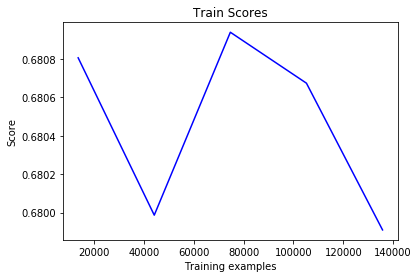

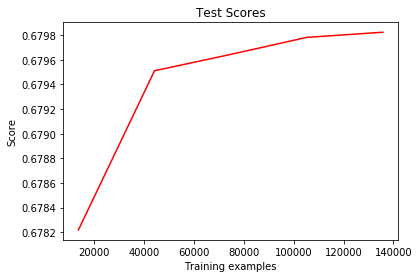

In [166]:
cv = ShuffleSplit(n_splits=5, test_size=0.5, random_state=9)

train_sizes,train_scores,test_scores = learning_curve(forest, X, np.ravel(Y),cv=cv)
plt.figure()
plt.title('Train Scores')
plt.plot(train_sizes, np.mean(train_scores,axis=1), color = 'b')
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.show()
plt.title('Test Scores')
plt.plot(train_sizes, np.mean(test_scores,axis=1),color='r')
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.show()


In [43]:
from sklearn.linear_model import LogisticRegression
X = X
Y = Y
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.48, test_size=.52,random_state=10)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(clf.coef_)
print(classification_report(Y_test,clf.predict(X_test)))

0.8634853860808351
[[-1.0234103   6.70174357  0.60273647]]
             precision    recall  f1-score   support

        0.0       0.98      0.60      0.74     46473
        1.0       0.83      0.99      0.91     94728

avg / total       0.88      0.86      0.85    141201



In [61]:
from sklearn.linear_model import LogisticRegressionCV
cv = ShuffleSplit(n_splits=15, test_size=0.48, random_state=10)
X = X
Y = Y
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.5, test_size=.5,random_state=10)
clf = LogisticRegressionCV(max_iter=1000,cv=cv,random_state = 10)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(clf.coef_)
print(classification_report(Y_test,clf.predict(X_test)))

0.8635633792443103
[[ 0.37714626 10.86493985 -0.81158822]]
             precision    recall  f1-score   support

        0.0       0.98      0.60      0.74     44634
        1.0       0.83      0.99      0.91     91136

avg / total       0.88      0.86      0.85    135770



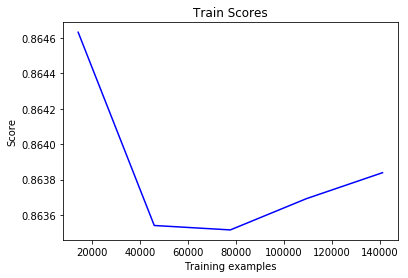

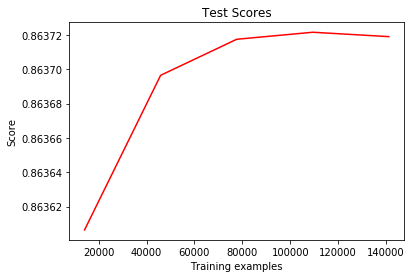

In [52]:
cv = ShuffleSplit(n_splits=15, test_size=0.48, random_state=10)

train_sizes,train_scores,test_scores = learning_curve(clf, X, np.ravel(Y),cv=cv)
plt.figure()
plt.title('Train Scores')
plt.plot(train_sizes, np.mean(train_scores,axis=1), color = 'b')
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.show()
plt.title('Test Scores')
plt.plot(train_sizes, np.mean(test_scores,axis=1),color='r')
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.show()


## Apply similar logic to the data in domain_df

In [3]:
domain_df = domain_df.merge(labels).dropna().reset_index(drop=True)

In [74]:
domain_df

,indicator,domain_name,domain_title,unsafe,ind_to_dom_name,ind_to_title
0,config01.homepc.it,dyndns.it,dyndns.it,1,14,14
1,config01.homepc.it,impulso.it,impulso.it,1,13,13
2,config01.homepc.it,ns0.it,ns0.it,1,13,13
3,config01.homepc.it,dyndns.it,dyndns.it,1,14,14
4,config01.homepc.it,impulso.it,impulso.it,1,13,13
5,config01.homepc.it,ns0.it,ns0.it,1,13,13
6,config01.homepc.it,dyndns.it,dyndns.it,1,14,14
7,config01.homepc.it,impulso.it,impulso.it,1,13,13
8,config01.homepc.it,ns0.it,ns0.it,1,13,13
9,ing.com,ingfi.com,ingfi.com,1,2,2


In [79]:
ind_to_name = []
for i in range(len(domain_df['unsafe'])):
    ind_to_name.append(nltk.edit_distance(domain_df['indicator'][i],domain_df['domain_name'][i]))
domain_df['ind_to_dom_name'] =ind_to_name

ind_to_title = []
for i in range(len(domain_df['unsafe'])):
    ind_to_title.append(nltk.edit_distance(domain_df['indicator'][i],domain_df['domain_title'][i]))
domain_df['ind_to_title'] =ind_to_title

name_to_title=[]
for i in range(len(domain_df['unsafe'])):
    name_to_title.append(nltk.edit_distance(domain_df['domain_name'][i],domain_df['domain_title'][i]))
domain_df['name_to_title'] =name_to_title
domain_df.head()

KeyboardInterrupt: 

In [ ]:
domain_df['name_to_title'].sum()

In [83]:
X = domain_df[['ind_to_dom_name']]#.drop(columns=['indicator','domain_name','domain_title','unsafe'])
Y = domain_df[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.48, test_size=.52,random_state=10)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(*(list(zip(clf.coef_[0],X.columns))),sep='\n')
print(classification_report(Y_test,clf.predict(X_test)))

0.9127158167835192
(0.28784938080480793, 'ind_to_dom_name')
             precision    recall  f1-score   support

          0       0.92      0.99      0.95    111964
          1       0.84      0.44      0.58     17544

avg / total       0.91      0.91      0.90    129508



## Apply similar logic to the data in contr_subdom_df
Note: data seems to be very unbalanced

In [84]:
contr_subdom_df

,data_url,indicator,page_views_%,page_views_per_user,reach_%,time_range_days
0,arbuslavanderia.homepc.it,config01.homepc.it,85.86,30.00,50.45,30
1,scubadive66.homepc.it,config01.homepc.it,13.77,5.00,43.53,30
2,OTHER,config01.homepc.it,0.39,0.00,0.00,30
3,up.top4top.net,e.top4top.net,77.47,1.65,84.98,30
4,e.top4top.net,e.top4top.net,3.02,1.20,4.70,30
5,b.top4top.net,e.top4top.net,2.54,1.10,4.01,30
6,c.top4top.net,e.top4top.net,2.53,1.20,3.91,30
7,a.top4top.net,e.top4top.net,2.39,1.20,3.63,30
8,d.top4top.net,e.top4top.net,2.32,1.20,3.42,30
9,f.top4top.net,e.top4top.net,2.18,1.20,3.31,30


In [4]:
contr_subdom_df = contr_subdom_df.merge(labels)
contr_subdom_df.head()

,data_url,indicator,page_views_%,page_views_per_user,reach_%,time_range_days,unsafe
0,arbuslavanderia.homepc.it,config01.homepc.it,85.86,30.0,50.45,30,1
1,scubadive66.homepc.it,config01.homepc.it,13.77,5.0,43.53,30,1
2,OTHER,config01.homepc.it,0.39,0.0,0.00,30,1
3,arbuslavanderia.homepc.it,config01.homepc.it,75.28,30.0,50.75,30,1
4,scubadive66.homepc.it,config01.homepc.it,24.66,9.0,48.75,30,1


In [5]:
url_to_ind = []
for i in range(len(contr_subdom_df['unsafe'])):
    url_to_ind.append(nltk.edit_distance(contr_subdom_df['data_url'][i],contr_subdom_df['indicator'][i]))
contr_subdom_df['url_to_ind'] =url_to_ind
contr_subdom_df

,data_url,indicator,page_views_%,page_views_per_user,reach_%,time_range_days,unsafe,url_to_ind
0,arbuslavanderia.homepc.it,config01.homepc.it,85.86,30.00,50.45,30,1,14
1,scubadive66.homepc.it,config01.homepc.it,13.77,5.00,43.53,30,1,9
2,OTHER,config01.homepc.it,0.39,0.00,0.00,30,1,18
3,arbuslavanderia.homepc.it,config01.homepc.it,75.28,30.00,50.75,30,1,14
4,scubadive66.homepc.it,config01.homepc.it,24.66,9.00,48.75,30,1,9
5,OTHER,config01.homepc.it,0.06,0.00,0.00,30,1,18
6,arbuslavanderia.homepc.it,config01.homepc.it,89.11,10.00,77.74,30,1,14
7,OTHER,config01.homepc.it,10.89,0.00,0.00,30,1,18
8,up.top4top.net,e.top4top.net,77.47,1.65,84.98,30,1,2
9,e.top4top.net,e.top4top.net,3.02,1.20,4.70,30,1,0


In [7]:
contr_subdom_df.to_parquet('contributing_subdomain_df.gzip',compression='gzip')

In [31]:
X = contr_subdom_df.drop(columns=['indicator','data_url','unsafe'])
Y = contr_subdom_df[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.48, test_size=.52,random_state=10)
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(*(list(zip(clf.coef_[0],X.columns))),sep='\n')
print(classification_report(Y_test,clf.predict(X_test)))

0.8746478838987591
(0.035160975628422325, 'page_views_%')
(0.05532308161414353, 'page_views_per_user')
(-0.02734741577048913, 'reach_%')
(-0.11193121279509512, 'time_range_days')
(0.12409215344374731, 'url_to_ind')
             precision    recall  f1-score   support

          0       0.88      0.99      0.93   1033609
          1       0.82      0.29      0.43    200004

avg / total       0.87      0.87      0.85   1233613



In [30]:
from sklearn.linear_model import SGDClassifier
X = contr_subdom_df.drop(columns=['indicator','data_url','unsafe'])
Y = contr_subdom_df[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.75, test_size=.25,random_state=10)
clf = SGDClassifier(loss ='log',max_iter = 3000,random_state=10)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(*(list(zip(clf.coef_[0],X.columns))),sep='\n')
print(classification_report(Y_test,clf.predict(X_test)))
clf.n_iter_

-- Epoch 1
Norm: 0.54, NNZs: 5, Bias: -15.319766, T: 1779248, Avg. loss: 8.011812
Total training time: 0.36 seconds.
-- Epoch 2
Norm: 0.53, NNZs: 5, Bias: -15.309508, T: 3558496, Avg. loss: 0.780513
Total training time: 0.74 seconds.
-- Epoch 3
Norm: 0.45, NNZs: 5, Bias: -15.305875, T: 5337744, Avg. loss: 0.557133
Total training time: 1.12 seconds.
-- Epoch 4
Norm: 0.45, NNZs: 5, Bias: -15.300605, T: 7116992, Avg. loss: 0.480437
Total training time: 1.51 seconds.
-- Epoch 5
Norm: 0.48, NNZs: 5, Bias: -15.296373, T: 8896240, Avg. loss: 0.442563
Total training time: 1.89 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 5, Bias: -15.294768, T: 10675488, Avg. loss: 0.420121
Total training time: 2.27 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 5, Bias: -15.293250, T: 12454736, Avg. loss: 0.405640
Total training time: 2.65 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 5, Bias: -15.290801, T: 14233984, Avg. loss: 0.395936
Total training time: 3.03 seconds.
-- Epoch 9
Norm: 0.41, NNZs: 5, Bias: -15.290247, T: 16013232

Norm: 0.41, NNZs: 5, Bias: -15.262903, T: 124547360, Avg. loss: 0.352932
Total training time: 26.72 seconds.
-- Epoch 71
Norm: 0.42, NNZs: 5, Bias: -15.262445, T: 126326608, Avg. loss: 0.352930
Total training time: 27.11 seconds.
-- Epoch 72
Norm: 0.42, NNZs: 5, Bias: -15.262341, T: 128105856, Avg. loss: 0.352860
Total training time: 27.49 seconds.
-- Epoch 73
Norm: 0.43, NNZs: 5, Bias: -15.261839, T: 129885104, Avg. loss: 0.352786
Total training time: 27.87 seconds.
-- Epoch 74
Norm: 0.43, NNZs: 5, Bias: -15.261689, T: 131664352, Avg. loss: 0.352811
Total training time: 28.25 seconds.
-- Epoch 75
Norm: 0.43, NNZs: 5, Bias: -15.261398, T: 133443600, Avg. loss: 0.352702
Total training time: 28.63 seconds.
-- Epoch 76
Norm: 0.43, NNZs: 5, Bias: -15.261335, T: 135222848, Avg. loss: 0.352705
Total training time: 29.00 seconds.
-- Epoch 77
Norm: 0.41, NNZs: 5, Bias: -15.261646, T: 137002096, Avg. loss: 0.352632
Total training time: 29.38 seconds.
-- Epoch 78
Norm: 0.42, NNZs: 5, Bias: -15.2

Norm: 0.42, NNZs: 5, Bias: -15.253631, T: 245536224, Avg. loss: 0.351244
Total training time: 52.67 seconds.
-- Epoch 139
Norm: 0.42, NNZs: 5, Bias: -15.253695, T: 247315472, Avg. loss: 0.351215
Total training time: 53.05 seconds.
-- Epoch 140
Norm: 0.42, NNZs: 5, Bias: -15.253445, T: 249094720, Avg. loss: 0.351215
Total training time: 53.44 seconds.
-- Epoch 141
Norm: 0.42, NNZs: 5, Bias: -15.253502, T: 250873968, Avg. loss: 0.351218
Total training time: 53.82 seconds.
-- Epoch 142
Norm: 0.42, NNZs: 5, Bias: -15.253295, T: 252653216, Avg. loss: 0.351177
Total training time: 54.19 seconds.
-- Epoch 143
Norm: 0.42, NNZs: 5, Bias: -15.253260, T: 254432464, Avg. loss: 0.351189
Total training time: 54.58 seconds.
-- Epoch 144
Norm: 0.42, NNZs: 5, Bias: -15.253250, T: 256211712, Avg. loss: 0.351176
Total training time: 54.97 seconds.
-- Epoch 145
Norm: 0.42, NNZs: 5, Bias: -15.252847, T: 257990960, Avg. loss: 0.351188
Total training time: 55.35 seconds.
-- Epoch 146
Norm: 0.42, NNZs: 5, Bia

Norm: 0.42, NNZs: 5, Bias: -15.248453, T: 366525088, Avg. loss: 0.350706
Total training time: 78.59 seconds.
-- Epoch 207
Norm: 0.43, NNZs: 5, Bias: -15.248167, T: 368304336, Avg. loss: 0.350701
Total training time: 78.97 seconds.
-- Epoch 208
Norm: 0.42, NNZs: 5, Bias: -15.248246, T: 370083584, Avg. loss: 0.350643
Total training time: 79.35 seconds.
-- Epoch 209
Norm: 0.42, NNZs: 5, Bias: -15.248306, T: 371862832, Avg. loss: 0.350691
Total training time: 79.73 seconds.
-- Epoch 210
Norm: 0.42, NNZs: 5, Bias: -15.248019, T: 373642080, Avg. loss: 0.350652
Total training time: 80.11 seconds.
-- Epoch 211
Norm: 0.42, NNZs: 5, Bias: -15.248012, T: 375421328, Avg. loss: 0.350669
Total training time: 80.49 seconds.
-- Epoch 212
Norm: 0.42, NNZs: 5, Bias: -15.248052, T: 377200576, Avg. loss: 0.350640
Total training time: 80.87 seconds.
-- Epoch 213
Norm: 0.42, NNZs: 5, Bias: -15.248083, T: 378979824, Avg. loss: 0.350640
Total training time: 81.25 seconds.
-- Epoch 214
Norm: 0.42, NNZs: 5, Bia

Norm: 0.42, NNZs: 5, Bias: -15.244612, T: 487513952, Avg. loss: 0.350411
Total training time: 104.43 seconds.
-- Epoch 275
Norm: 0.42, NNZs: 5, Bias: -15.244645, T: 489293200, Avg. loss: 0.350382
Total training time: 104.81 seconds.
-- Epoch 276
Norm: 0.42, NNZs: 5, Bias: -15.244526, T: 491072448, Avg. loss: 0.350382
Total training time: 105.18 seconds.
-- Epoch 277
Norm: 0.42, NNZs: 5, Bias: -15.244512, T: 492851696, Avg. loss: 0.350411
Total training time: 105.56 seconds.
-- Epoch 278
Norm: 0.42, NNZs: 5, Bias: -15.244469, T: 494630944, Avg. loss: 0.350407
Total training time: 105.95 seconds.
-- Epoch 279
Norm: 0.42, NNZs: 5, Bias: -15.244466, T: 496410192, Avg. loss: 0.350375
Total training time: 106.33 seconds.
-- Epoch 280
Norm: 0.42, NNZs: 5, Bias: -15.244200, T: 498189440, Avg. loss: 0.350384
Total training time: 106.71 seconds.
-- Epoch 281
Norm: 0.42, NNZs: 5, Bias: -15.244210, T: 499968688, Avg. loss: 0.350404
Total training time: 107.09 seconds.
-- Epoch 282
Norm: 0.42, NNZs

Norm: 0.42, NNZs: 5, Bias: -15.241781, T: 606723568, Avg. loss: 0.350220
Total training time: 130.01 seconds.
-- Epoch 342
Norm: 0.42, NNZs: 5, Bias: -15.241818, T: 608502816, Avg. loss: 0.350244
Total training time: 130.39 seconds.
-- Epoch 343
Norm: 0.42, NNZs: 5, Bias: -15.241634, T: 610282064, Avg. loss: 0.350240
Total training time: 130.79 seconds.
-- Epoch 344
Norm: 0.42, NNZs: 5, Bias: -15.241561, T: 612061312, Avg. loss: 0.350222
Total training time: 131.18 seconds.
-- Epoch 345
Norm: 0.42, NNZs: 5, Bias: -15.241584, T: 613840560, Avg. loss: 0.350234
Total training time: 131.58 seconds.
-- Epoch 346
Norm: 0.42, NNZs: 5, Bias: -15.241454, T: 615619808, Avg. loss: 0.350232
Total training time: 131.97 seconds.
-- Epoch 347
Norm: 0.42, NNZs: 5, Bias: -15.241601, T: 617399056, Avg. loss: 0.350226
Total training time: 132.36 seconds.
-- Epoch 348
Norm: 0.42, NNZs: 5, Bias: -15.241533, T: 619178304, Avg. loss: 0.350250
Total training time: 132.75 seconds.
-- Epoch 349
Norm: 0.42, NNZs

Norm: 0.42, NNZs: 5, Bias: -15.239539, T: 725933184, Avg. loss: 0.350117
Total training time: 155.94 seconds.
-- Epoch 409
Norm: 0.43, NNZs: 5, Bias: -15.239226, T: 727712432, Avg. loss: 0.350100
Total training time: 156.32 seconds.
-- Epoch 410
Norm: 0.42, NNZs: 5, Bias: -15.239183, T: 729491680, Avg. loss: 0.350111
Total training time: 156.69 seconds.
-- Epoch 411
Norm: 0.42, NNZs: 5, Bias: -15.239275, T: 731270928, Avg. loss: 0.350145
Total training time: 157.08 seconds.
-- Epoch 412
Norm: 0.43, NNZs: 5, Bias: -15.239024, T: 733050176, Avg. loss: 0.350117
Total training time: 157.46 seconds.
-- Epoch 413
Norm: 0.42, NNZs: 5, Bias: -15.239255, T: 734829424, Avg. loss: 0.350112
Total training time: 157.84 seconds.
-- Epoch 414
Norm: 0.42, NNZs: 5, Bias: -15.239240, T: 736608672, Avg. loss: 0.350108
Total training time: 158.22 seconds.
-- Epoch 415
Norm: 0.42, NNZs: 5, Bias: -15.239105, T: 738387920, Avg. loss: 0.350109
Total training time: 158.59 seconds.
-- Epoch 416
Norm: 0.42, NNZs

Norm: 0.42, NNZs: 5, Bias: -15.237305, T: 845142800, Avg. loss: 0.350027
Total training time: 181.54 seconds.
-- Epoch 476
Norm: 0.42, NNZs: 5, Bias: -15.237366, T: 846922048, Avg. loss: 0.350048
Total training time: 181.92 seconds.
-- Epoch 477
Norm: 0.42, NNZs: 5, Bias: -15.237325, T: 848701296, Avg. loss: 0.350054
Total training time: 182.31 seconds.
-- Epoch 478
Norm: 0.42, NNZs: 5, Bias: -15.237276, T: 850480544, Avg. loss: 0.350045
Total training time: 182.69 seconds.
-- Epoch 479
Norm: 0.42, NNZs: 5, Bias: -15.237234, T: 852259792, Avg. loss: 0.350050
Total training time: 183.07 seconds.
-- Epoch 480
Norm: 0.42, NNZs: 5, Bias: -15.237246, T: 854039040, Avg. loss: 0.350052
Total training time: 183.45 seconds.
-- Epoch 481
Norm: 0.43, NNZs: 5, Bias: -15.237017, T: 855818288, Avg. loss: 0.350046
Total training time: 183.83 seconds.
-- Epoch 482
Norm: 0.42, NNZs: 5, Bias: -15.237104, T: 857597536, Avg. loss: 0.350052
Total training time: 184.21 seconds.
-- Epoch 483
Norm: 0.42, NNZs

Norm: 0.42, NNZs: 5, Bias: -15.235590, T: 964352416, Avg. loss: 0.349998
Total training time: 207.07 seconds.
-- Epoch 543
Norm: 0.42, NNZs: 5, Bias: -15.235667, T: 966131664, Avg. loss: 0.349972
Total training time: 207.44 seconds.
-- Epoch 544
Norm: 0.42, NNZs: 5, Bias: -15.235602, T: 967910912, Avg. loss: 0.349968
Total training time: 207.82 seconds.
-- Epoch 545
Norm: 0.42, NNZs: 5, Bias: -15.235496, T: 969690160, Avg. loss: 0.349985
Total training time: 208.21 seconds.
-- Epoch 546
Norm: 0.42, NNZs: 5, Bias: -15.235609, T: 971469408, Avg. loss: 0.349973
Total training time: 208.59 seconds.
-- Epoch 547
Norm: 0.42, NNZs: 5, Bias: -15.235610, T: 973248656, Avg. loss: 0.349982
Total training time: 208.97 seconds.
-- Epoch 548
Norm: 0.42, NNZs: 5, Bias: -15.235608, T: 975027904, Avg. loss: 0.349980
Total training time: 209.35 seconds.
-- Epoch 549
Norm: 0.42, NNZs: 5, Bias: -15.235498, T: 976807152, Avg. loss: 0.349994
Total training time: 209.73 seconds.
-- Epoch 550
Norm: 0.42, NNZs

Norm: 0.42, NNZs: 5, Bias: -15.234119, T: 1083562032, Avg. loss: 0.349931
Total training time: 232.55 seconds.
-- Epoch 610
Norm: 0.42, NNZs: 5, Bias: -15.234115, T: 1085341280, Avg. loss: 0.349960
Total training time: 232.94 seconds.
-- Epoch 611
Norm: 0.42, NNZs: 5, Bias: -15.233992, T: 1087120528, Avg. loss: 0.349934
Total training time: 233.32 seconds.
-- Epoch 612
Norm: 0.42, NNZs: 5, Bias: -15.234035, T: 1088899776, Avg. loss: 0.349925
Total training time: 233.70 seconds.
-- Epoch 613
Norm: 0.42, NNZs: 5, Bias: -15.234053, T: 1090679024, Avg. loss: 0.349949
Total training time: 234.08 seconds.
-- Epoch 614
Norm: 0.42, NNZs: 5, Bias: -15.233950, T: 1092458272, Avg. loss: 0.349949
Total training time: 234.46 seconds.
-- Epoch 615
Norm: 0.43, NNZs: 5, Bias: -15.233803, T: 1094237520, Avg. loss: 0.349940
Total training time: 234.84 seconds.
-- Epoch 616
Norm: 0.42, NNZs: 5, Bias: -15.234002, T: 1096016768, Avg. loss: 0.349937
Total training time: 235.22 seconds.
-- Epoch 617
Norm: 0.

Norm: 0.42, NNZs: 5, Bias: -15.232578, T: 1202771648, Avg. loss: 0.349891
Total training time: 258.09 seconds.
-- Epoch 677
Norm: 0.42, NNZs: 5, Bias: -15.232649, T: 1204550896, Avg. loss: 0.349899
Total training time: 258.47 seconds.
-- Epoch 678
Norm: 0.42, NNZs: 5, Bias: -15.232610, T: 1206330144, Avg. loss: 0.349902
Total training time: 258.85 seconds.
-- Epoch 679
Norm: 0.42, NNZs: 5, Bias: -15.232603, T: 1208109392, Avg. loss: 0.349894
Total training time: 259.23 seconds.
-- Epoch 680
Norm: 0.42, NNZs: 5, Bias: -15.232535, T: 1209888640, Avg. loss: 0.349903
Total training time: 259.61 seconds.
-- Epoch 681
Norm: 0.42, NNZs: 5, Bias: -15.232686, T: 1211667888, Avg. loss: 0.349909
Total training time: 260.00 seconds.
-- Epoch 682
Norm: 0.42, NNZs: 5, Bias: -15.232586, T: 1213447136, Avg. loss: 0.349918
Total training time: 260.37 seconds.
-- Epoch 683
Norm: 0.42, NNZs: 5, Bias: -15.232539, T: 1215226384, Avg. loss: 0.349892
Total training time: 260.75 seconds.
-- Epoch 684
Norm: 0.

Norm: 0.42, NNZs: 5, Bias: -15.231481, T: 1321981264, Avg. loss: 0.349884
Total training time: 283.56 seconds.
-- Epoch 744
Norm: 0.42, NNZs: 5, Bias: -15.231435, T: 1323760512, Avg. loss: 0.349875
Total training time: 283.94 seconds.
-- Epoch 745
Norm: 0.42, NNZs: 5, Bias: -15.231461, T: 1325539760, Avg. loss: 0.349871
Total training time: 284.32 seconds.
-- Epoch 746
Norm: 0.42, NNZs: 5, Bias: -15.231529, T: 1327319008, Avg. loss: 0.349853
Total training time: 284.70 seconds.
-- Epoch 747
Norm: 0.42, NNZs: 5, Bias: -15.231350, T: 1329098256, Avg. loss: 0.349855
Total training time: 285.08 seconds.
-- Epoch 748
Norm: 0.42, NNZs: 5, Bias: -15.231395, T: 1330877504, Avg. loss: 0.349872
Total training time: 285.46 seconds.
-- Epoch 749
Norm: 0.42, NNZs: 5, Bias: -15.231244, T: 1332656752, Avg. loss: 0.349870
Total training time: 285.84 seconds.
-- Epoch 750
Norm: 0.42, NNZs: 5, Bias: -15.231407, T: 1334436000, Avg. loss: 0.349874
Total training time: 286.22 seconds.
-- Epoch 751
Norm: 0.

Norm: 0.42, NNZs: 5, Bias: -15.230283, T: 1441190880, Avg. loss: 0.349839
Total training time: 309.16 seconds.
-- Epoch 811
Norm: 0.43, NNZs: 5, Bias: -15.230134, T: 1442970128, Avg. loss: 0.349838
Total training time: 309.54 seconds.
-- Epoch 812
Norm: 0.42, NNZs: 5, Bias: -15.230324, T: 1444749376, Avg. loss: 0.349835
Total training time: 309.92 seconds.
-- Epoch 813
Norm: 0.42, NNZs: 5, Bias: -15.230318, T: 1446528624, Avg. loss: 0.349846
Total training time: 310.30 seconds.
-- Epoch 814
Norm: 0.42, NNZs: 5, Bias: -15.230420, T: 1448307872, Avg. loss: 0.349856
Total training time: 310.68 seconds.
-- Epoch 815
Norm: 0.42, NNZs: 5, Bias: -15.230227, T: 1450087120, Avg. loss: 0.349843
Total training time: 311.06 seconds.
-- Epoch 816
Norm: 0.42, NNZs: 5, Bias: -15.230208, T: 1451866368, Avg. loss: 0.349852
Total training time: 311.44 seconds.
-- Epoch 817
Norm: 0.42, NNZs: 5, Bias: -15.230172, T: 1453645616, Avg. loss: 0.349846
Total training time: 311.81 seconds.
-- Epoch 818
Norm: 0.

Norm: 0.42, NNZs: 5, Bias: -15.229288, T: 1560400496, Avg. loss: 0.349821
Total training time: 334.75 seconds.
-- Epoch 878
Norm: 0.42, NNZs: 5, Bias: -15.229294, T: 1562179744, Avg. loss: 0.349834
Total training time: 335.13 seconds.
-- Epoch 879
Norm: 0.42, NNZs: 5, Bias: -15.229309, T: 1563958992, Avg. loss: 0.349821
Total training time: 335.51 seconds.
-- Epoch 880
Norm: 0.42, NNZs: 5, Bias: -15.229321, T: 1565738240, Avg. loss: 0.349821
Total training time: 335.88 seconds.
-- Epoch 881
Norm: 0.42, NNZs: 5, Bias: -15.229316, T: 1567517488, Avg. loss: 0.349813
Total training time: 336.27 seconds.
-- Epoch 882
Norm: 0.42, NNZs: 5, Bias: -15.229193, T: 1569296736, Avg. loss: 0.349832
Total training time: 336.65 seconds.
-- Epoch 883
Norm: 0.42, NNZs: 5, Bias: -15.229206, T: 1571075984, Avg. loss: 0.349797
Total training time: 337.04 seconds.
-- Epoch 884
Norm: 0.42, NNZs: 5, Bias: -15.229102, T: 1572855232, Avg. loss: 0.349796
Total training time: 337.42 seconds.
-- Epoch 885
Norm: 0.

Norm: 0.42, NNZs: 5, Bias: -15.228307, T: 1679610112, Avg. loss: 0.349797
Total training time: 360.26 seconds.
-- Epoch 945
Norm: 0.42, NNZs: 5, Bias: -15.228185, T: 1681389360, Avg. loss: 0.349816
Total training time: 360.64 seconds.
-- Epoch 946
Norm: 0.42, NNZs: 5, Bias: -15.228294, T: 1683168608, Avg. loss: 0.349803
Total training time: 361.02 seconds.
-- Epoch 947
Norm: 0.42, NNZs: 5, Bias: -15.228212, T: 1684947856, Avg. loss: 0.349811
Total training time: 361.40 seconds.
-- Epoch 948
Norm: 0.42, NNZs: 5, Bias: -15.228261, T: 1686727104, Avg. loss: 0.349816
Total training time: 361.77 seconds.
-- Epoch 949
Norm: 0.42, NNZs: 5, Bias: -15.228229, T: 1688506352, Avg. loss: 0.349827
Total training time: 362.16 seconds.
-- Epoch 950
Norm: 0.42, NNZs: 5, Bias: -15.228246, T: 1690285600, Avg. loss: 0.349794
Total training time: 362.53 seconds.
-- Epoch 951
Norm: 0.42, NNZs: 5, Bias: -15.228188, T: 1692064848, Avg. loss: 0.349815
Total training time: 362.91 seconds.
-- Epoch 952
Norm: 0.

Norm: 0.42, NNZs: 5, Bias: -15.227359, T: 1797040480, Avg. loss: 0.349790
Total training time: 385.37 seconds.
-- Epoch 1011
Norm: 0.42, NNZs: 5, Bias: -15.227402, T: 1798819728, Avg. loss: 0.349772
Total training time: 385.76 seconds.
-- Epoch 1012
Norm: 0.42, NNZs: 5, Bias: -15.227450, T: 1800598976, Avg. loss: 0.349787
Total training time: 386.14 seconds.
-- Epoch 1013
Norm: 0.42, NNZs: 5, Bias: -15.227320, T: 1802378224, Avg. loss: 0.349802
Total training time: 386.52 seconds.
-- Epoch 1014
Norm: 0.42, NNZs: 5, Bias: -15.227429, T: 1804157472, Avg. loss: 0.349795
Total training time: 386.90 seconds.
-- Epoch 1015
Norm: 0.42, NNZs: 5, Bias: -15.227359, T: 1805936720, Avg. loss: 0.349795
Total training time: 387.29 seconds.
-- Epoch 1016
Norm: 0.42, NNZs: 5, Bias: -15.227382, T: 1807715968, Avg. loss: 0.349782
Total training time: 387.67 seconds.
-- Epoch 1017
Norm: 0.42, NNZs: 5, Bias: -15.227411, T: 1809495216, Avg. loss: 0.349787
Total training time: 388.05 seconds.
-- Epoch 1018


Norm: 0.42, NNZs: 5, Bias: -15.226646, T: 1914470848, Avg. loss: 0.349780
Total training time: 410.65 seconds.
-- Epoch 1077
Norm: 0.42, NNZs: 5, Bias: -15.226501, T: 1916250096, Avg. loss: 0.349772
Total training time: 411.03 seconds.
-- Epoch 1078
Norm: 0.42, NNZs: 5, Bias: -15.226651, T: 1918029344, Avg. loss: 0.349772
Total training time: 411.41 seconds.
-- Epoch 1079
Norm: 0.42, NNZs: 5, Bias: -15.226552, T: 1919808592, Avg. loss: 0.349770
Total training time: 411.79 seconds.
-- Epoch 1080
Norm: 0.42, NNZs: 5, Bias: -15.226577, T: 1921587840, Avg. loss: 0.349782
Total training time: 412.17 seconds.
-- Epoch 1081
Norm: 0.42, NNZs: 5, Bias: -15.226496, T: 1923367088, Avg. loss: 0.349771
Total training time: 412.55 seconds.
-- Epoch 1082
Norm: 0.42, NNZs: 5, Bias: -15.226591, T: 1925146336, Avg. loss: 0.349762
Total training time: 412.93 seconds.
-- Epoch 1083
Norm: 0.42, NNZs: 5, Bias: -15.226556, T: 1926925584, Avg. loss: 0.349774
Total training time: 413.31 seconds.
-- Epoch 1084


Norm: 0.42, NNZs: 5, Bias: -15.225825, T: 2031901216, Avg. loss: 0.349770
Total training time: 435.78 seconds.
-- Epoch 1143
Norm: 0.42, NNZs: 5, Bias: -15.225737, T: 2033680464, Avg. loss: 0.349754
Total training time: 436.16 seconds.
-- Epoch 1144
Norm: 0.42, NNZs: 5, Bias: -15.225723, T: 2035459712, Avg. loss: 0.349760
Total training time: 436.55 seconds.
-- Epoch 1145
Norm: 0.42, NNZs: 5, Bias: -15.225827, T: 2037238960, Avg. loss: 0.349753
Total training time: 436.93 seconds.
-- Epoch 1146
Norm: 0.42, NNZs: 5, Bias: -15.225753, T: 2039018208, Avg. loss: 0.349755
Total training time: 437.31 seconds.
-- Epoch 1147
Norm: 0.42, NNZs: 5, Bias: -15.225679, T: 2040797456, Avg. loss: 0.349761
Total training time: 437.69 seconds.
-- Epoch 1148
Norm: 0.42, NNZs: 5, Bias: -15.225731, T: 2042576704, Avg. loss: 0.349759
Total training time: 438.07 seconds.
-- Epoch 1149
Norm: 0.42, NNZs: 5, Bias: -15.225690, T: 2044355952, Avg. loss: 0.349764
Total training time: 438.45 seconds.
-- Epoch 1150


Norm: 0.42, NNZs: 5, Bias: -15.225066, T: 2149331584, Avg. loss: 0.349749
Total training time: 460.89 seconds.
-- Epoch 1209
Norm: 0.42, NNZs: 5, Bias: -15.225085, T: 2151110832, Avg. loss: 0.349749
Total training time: 461.27 seconds.
-- Epoch 1210
Norm: 0.42, NNZs: 5, Bias: -15.225032, T: 2152890080, Avg. loss: 0.349740
Total training time: 461.65 seconds.
-- Epoch 1211
Norm: 0.42, NNZs: 5, Bias: -15.225022, T: 2154669328, Avg. loss: 0.349752
Total training time: 462.03 seconds.
-- Epoch 1212
Norm: 0.42, NNZs: 5, Bias: -15.225026, T: 2156448576, Avg. loss: 0.349757
Total training time: 462.41 seconds.
-- Epoch 1213
Norm: 0.42, NNZs: 5, Bias: -15.224966, T: 2158227824, Avg. loss: 0.349758
Total training time: 462.80 seconds.
-- Epoch 1214
Norm: 0.42, NNZs: 5, Bias: -15.224909, T: 2160007072, Avg. loss: 0.349743
Total training time: 463.18 seconds.
-- Epoch 1215
Norm: 0.42, NNZs: 5, Bias: -15.224936, T: 2161786320, Avg. loss: 0.349736
Total training time: 463.56 seconds.
-- Epoch 1216


Norm: 0.42, NNZs: 5, Bias: -15.224368, T: 2266761952, Avg. loss: 0.349741
Total training time: 486.22 seconds.
-- Epoch 1275
Norm: 0.42, NNZs: 5, Bias: -15.224248, T: 2268541200, Avg. loss: 0.349734
Total training time: 486.61 seconds.
-- Epoch 1276
Norm: 0.42, NNZs: 5, Bias: -15.224334, T: 2270320448, Avg. loss: 0.349743
Total training time: 487.00 seconds.
-- Epoch 1277
Norm: 0.42, NNZs: 5, Bias: -15.224324, T: 2272099696, Avg. loss: 0.349731
Total training time: 487.38 seconds.
-- Epoch 1278
Norm: 0.42, NNZs: 5, Bias: -15.224409, T: 2273878944, Avg. loss: 0.349738
Total training time: 487.77 seconds.
-- Epoch 1279
Norm: 0.42, NNZs: 5, Bias: -15.224292, T: 2275658192, Avg. loss: 0.349751
Total training time: 488.16 seconds.
-- Epoch 1280
Norm: 0.42, NNZs: 5, Bias: -15.224333, T: 2277437440, Avg. loss: 0.349742
Total training time: 488.54 seconds.
-- Epoch 1281
Norm: 0.42, NNZs: 5, Bias: -15.224325, T: 2279216688, Avg. loss: 0.349738
Total training time: 488.92 seconds.
-- Epoch 1282


Norm: 0.42, NNZs: 5, Bias: -15.223675, T: 2384192320, Avg. loss: 0.349725
Total training time: 511.37 seconds.
-- Epoch 1341
Norm: 0.42, NNZs: 5, Bias: -15.223700, T: 2385971568, Avg. loss: 0.349724
Total training time: 511.75 seconds.
-- Epoch 1342
Norm: 0.42, NNZs: 5, Bias: -15.223693, T: 2387750816, Avg. loss: 0.349738
Total training time: 512.13 seconds.
-- Epoch 1343
Norm: 0.42, NNZs: 5, Bias: -15.223683, T: 2389530064, Avg. loss: 0.349732
Total training time: 512.51 seconds.
-- Epoch 1344
Norm: 0.42, NNZs: 5, Bias: -15.223714, T: 2391309312, Avg. loss: 0.349720
Total training time: 512.89 seconds.
-- Epoch 1345
Norm: 0.42, NNZs: 5, Bias: -15.223638, T: 2393088560, Avg. loss: 0.349734
Total training time: 513.27 seconds.
-- Epoch 1346
Norm: 0.42, NNZs: 5, Bias: -15.223663, T: 2394867808, Avg. loss: 0.349737
Total training time: 513.65 seconds.
-- Epoch 1347
Norm: 0.42, NNZs: 5, Bias: -15.223611, T: 2396647056, Avg. loss: 0.349726
Total training time: 514.03 seconds.
-- Epoch 1348


Norm: 0.42, NNZs: 5, Bias: -15.223025, T: 2501622688, Avg. loss: 0.349729
Total training time: 536.47 seconds.
-- Epoch 1407
Norm: 0.42, NNZs: 5, Bias: -15.223059, T: 2503401936, Avg. loss: 0.349712
Total training time: 536.85 seconds.
-- Epoch 1408
Norm: 0.42, NNZs: 5, Bias: -15.223045, T: 2505181184, Avg. loss: 0.349731
Total training time: 537.24 seconds.
-- Epoch 1409
Norm: 0.42, NNZs: 5, Bias: -15.222931, T: 2506960432, Avg. loss: 0.349716
Total training time: 537.63 seconds.
-- Epoch 1410
Norm: 0.42, NNZs: 5, Bias: -15.223112, T: 2508739680, Avg. loss: 0.349738
Total training time: 538.01 seconds.
-- Epoch 1411
Norm: 0.42, NNZs: 5, Bias: -15.223000, T: 2510518928, Avg. loss: 0.349727
Total training time: 538.40 seconds.
-- Epoch 1412
Norm: 0.42, NNZs: 5, Bias: -15.223113, T: 2512298176, Avg. loss: 0.349723
Total training time: 538.79 seconds.
-- Epoch 1413
Norm: 0.42, NNZs: 5, Bias: -15.222851, T: 2514077424, Avg. loss: 0.349717
Total training time: 539.17 seconds.
-- Epoch 1414


Norm: 0.42, NNZs: 5, Bias: -15.222438, T: 2619053056, Avg. loss: 0.349717
Total training time: 561.70 seconds.
-- Epoch 1473
Norm: 0.42, NNZs: 5, Bias: -15.222496, T: 2620832304, Avg. loss: 0.349711
Total training time: 562.09 seconds.
-- Epoch 1474
Norm: 0.42, NNZs: 5, Bias: -15.222480, T: 2622611552, Avg. loss: 0.349714
Total training time: 562.47 seconds.
-- Epoch 1475
Norm: 0.42, NNZs: 5, Bias: -15.222321, T: 2624390800, Avg. loss: 0.349732
Total training time: 562.86 seconds.
-- Epoch 1476
Norm: 0.42, NNZs: 5, Bias: -15.222415, T: 2626170048, Avg. loss: 0.349727
Total training time: 563.24 seconds.
-- Epoch 1477
Norm: 0.42, NNZs: 5, Bias: -15.222417, T: 2627949296, Avg. loss: 0.349718
Total training time: 563.63 seconds.
-- Epoch 1478
Norm: 0.42, NNZs: 5, Bias: -15.222371, T: 2629728544, Avg. loss: 0.349714
Total training time: 564.02 seconds.
-- Epoch 1479
Norm: 0.42, NNZs: 5, Bias: -15.222421, T: 2631507792, Avg. loss: 0.349719
Total training time: 564.40 seconds.
-- Epoch 1480


Norm: 0.42, NNZs: 5, Bias: -15.221913, T: 2736483424, Avg. loss: 0.349708
Total training time: 586.95 seconds.
-- Epoch 1539
Norm: 0.42, NNZs: 5, Bias: -15.221935, T: 2738262672, Avg. loss: 0.349718
Total training time: 587.34 seconds.
-- Epoch 1540
Norm: 0.42, NNZs: 5, Bias: -15.221847, T: 2740041920, Avg. loss: 0.349701
Total training time: 587.72 seconds.
-- Epoch 1541
Norm: 0.42, NNZs: 5, Bias: -15.221747, T: 2741821168, Avg. loss: 0.349710
Total training time: 588.10 seconds.
-- Epoch 1542
Norm: 0.42, NNZs: 5, Bias: -15.221932, T: 2743600416, Avg. loss: 0.349692
Total training time: 588.49 seconds.
-- Epoch 1543
Norm: 0.42, NNZs: 5, Bias: -15.221852, T: 2745379664, Avg. loss: 0.349716
Total training time: 588.87 seconds.
-- Epoch 1544
Norm: 0.42, NNZs: 5, Bias: -15.221784, T: 2747158912, Avg. loss: 0.349708
Total training time: 589.26 seconds.
-- Epoch 1545
Norm: 0.42, NNZs: 5, Bias: -15.221908, T: 2748938160, Avg. loss: 0.349708
Total training time: 589.64 seconds.
-- Epoch 1546


Norm: 0.42, NNZs: 5, Bias: -15.221323, T: 2853913792, Avg. loss: 0.349722
Total training time: 612.28 seconds.
-- Epoch 1605
Norm: 0.42, NNZs: 5, Bias: -15.221342, T: 2855693040, Avg. loss: 0.349704
Total training time: 612.66 seconds.
-- Epoch 1606
Norm: 0.42, NNZs: 5, Bias: -15.221239, T: 2857472288, Avg. loss: 0.349694
Total training time: 613.04 seconds.
-- Epoch 1607
Norm: 0.42, NNZs: 5, Bias: -15.221323, T: 2859251536, Avg. loss: 0.349711
Total training time: 613.42 seconds.
-- Epoch 1608
Norm: 0.42, NNZs: 5, Bias: -15.221240, T: 2861030784, Avg. loss: 0.349703
Total training time: 613.80 seconds.
-- Epoch 1609
Norm: 0.42, NNZs: 5, Bias: -15.221260, T: 2862810032, Avg. loss: 0.349705
Total training time: 614.18 seconds.
-- Epoch 1610
Norm: 0.42, NNZs: 5, Bias: -15.221291, T: 2864589280, Avg. loss: 0.349701
Total training time: 614.57 seconds.
-- Epoch 1611
Norm: 0.42, NNZs: 5, Bias: -15.221240, T: 2866368528, Avg. loss: 0.349696
Total training time: 614.95 seconds.
-- Epoch 1612


Norm: 0.42, NNZs: 5, Bias: -15.220747, T: 2971344160, Avg. loss: 0.349702
Total training time: 637.38 seconds.
-- Epoch 1671
Norm: 0.42, NNZs: 5, Bias: -15.220786, T: 2973123408, Avg. loss: 0.349692
Total training time: 637.76 seconds.
-- Epoch 1672
Norm: 0.42, NNZs: 5, Bias: -15.220851, T: 2974902656, Avg. loss: 0.349706
Total training time: 638.14 seconds.
-- Epoch 1673
Norm: 0.42, NNZs: 5, Bias: -15.220765, T: 2976681904, Avg. loss: 0.349695
Total training time: 638.51 seconds.
-- Epoch 1674
Norm: 0.42, NNZs: 5, Bias: -15.220757, T: 2978461152, Avg. loss: 0.349692
Total training time: 638.89 seconds.
-- Epoch 1675
Norm: 0.42, NNZs: 5, Bias: -15.220796, T: 2980240400, Avg. loss: 0.349705
Total training time: 639.27 seconds.
-- Epoch 1676
Norm: 0.42, NNZs: 5, Bias: -15.220777, T: 2982019648, Avg. loss: 0.349696
Total training time: 639.66 seconds.
-- Epoch 1677
Norm: 0.42, NNZs: 5, Bias: -15.220722, T: 2983798896, Avg. loss: 0.349691
Total training time: 640.04 seconds.
-- Epoch 1678


Norm: 0.42, NNZs: 5, Bias: -15.220304, T: 3088774528, Avg. loss: 0.349701
Total training time: 662.56 seconds.
-- Epoch 1737
Norm: 0.42, NNZs: 5, Bias: -15.220294, T: 3090553776, Avg. loss: 0.349699
Total training time: 662.94 seconds.
-- Epoch 1738
Norm: 0.42, NNZs: 5, Bias: -15.220327, T: 3092333024, Avg. loss: 0.349698
Total training time: 663.32 seconds.
-- Epoch 1739
Norm: 0.42, NNZs: 5, Bias: -15.220259, T: 3094112272, Avg. loss: 0.349691
Total training time: 663.70 seconds.
-- Epoch 1740
Norm: 0.42, NNZs: 5, Bias: -15.220210, T: 3095891520, Avg. loss: 0.349698
Total training time: 664.08 seconds.
-- Epoch 1741
Norm: 0.42, NNZs: 5, Bias: -15.220207, T: 3097670768, Avg. loss: 0.349687
Total training time: 664.46 seconds.
-- Epoch 1742
Norm: 0.42, NNZs: 5, Bias: -15.220273, T: 3099450016, Avg. loss: 0.349697
Total training time: 664.84 seconds.
-- Epoch 1743
Norm: 0.42, NNZs: 5, Bias: -15.220200, T: 3101229264, Avg. loss: 0.349704
Total training time: 665.22 seconds.
-- Epoch 1744


Norm: 0.42, NNZs: 5, Bias: -15.219755, T: 3206204896, Avg. loss: 0.349690
Total training time: 687.66 seconds.
-- Epoch 1803
Norm: 0.42, NNZs: 5, Bias: -15.219809, T: 3207984144, Avg. loss: 0.349683
Total training time: 688.04 seconds.
-- Epoch 1804
Norm: 0.42, NNZs: 5, Bias: -15.219813, T: 3209763392, Avg. loss: 0.349681
Total training time: 688.42 seconds.
-- Epoch 1805
Norm: 0.42, NNZs: 5, Bias: -15.219792, T: 3211542640, Avg. loss: 0.349681
Total training time: 688.80 seconds.
-- Epoch 1806
Norm: 0.42, NNZs: 5, Bias: -15.219817, T: 3213321888, Avg. loss: 0.349695
Total training time: 689.18 seconds.
-- Epoch 1807
Norm: 0.42, NNZs: 5, Bias: -15.219783, T: 3215101136, Avg. loss: 0.349688
Total training time: 689.56 seconds.
-- Epoch 1808
Norm: 0.42, NNZs: 5, Bias: -15.219696, T: 3216880384, Avg. loss: 0.349687
Total training time: 689.94 seconds.
-- Epoch 1809
Norm: 0.42, NNZs: 5, Bias: -15.219691, T: 3218659632, Avg. loss: 0.349689
Total training time: 690.32 seconds.
-- Epoch 1810


Norm: 0.42, NNZs: 5, Bias: -15.219341, T: 3323635264, Avg. loss: 0.349687
Total training time: 712.83 seconds.
-- Epoch 1869
Norm: 0.42, NNZs: 5, Bias: -15.219337, T: 3325414512, Avg. loss: 0.349686
Total training time: 713.21 seconds.
-- Epoch 1870
Norm: 0.42, NNZs: 5, Bias: -15.219355, T: 3327193760, Avg. loss: 0.349682
Total training time: 713.59 seconds.
-- Epoch 1871
Norm: 0.42, NNZs: 5, Bias: -15.219293, T: 3328973008, Avg. loss: 0.349680
Total training time: 713.97 seconds.
-- Epoch 1872
Norm: 0.42, NNZs: 5, Bias: -15.219306, T: 3330752256, Avg. loss: 0.349683
Total training time: 714.35 seconds.
-- Epoch 1873
Norm: 0.42, NNZs: 5, Bias: -15.219280, T: 3332531504, Avg. loss: 0.349689
Total training time: 714.74 seconds.
-- Epoch 1874
Norm: 0.42, NNZs: 5, Bias: -15.219281, T: 3334310752, Avg. loss: 0.349685
Total training time: 715.12 seconds.
-- Epoch 1875
Norm: 0.42, NNZs: 5, Bias: -15.219278, T: 3336090000, Avg. loss: 0.349681
Total training time: 715.50 seconds.
-- Epoch 1876


Norm: 0.42, NNZs: 5, Bias: -15.218895, T: 3441065632, Avg. loss: 0.349670
Total training time: 738.06 seconds.
-- Epoch 1935
Norm: 0.42, NNZs: 5, Bias: -15.218840, T: 3442844880, Avg. loss: 0.349685
Total training time: 738.44 seconds.
-- Epoch 1936
Norm: 0.42, NNZs: 5, Bias: -15.218818, T: 3444624128, Avg. loss: 0.349681
Total training time: 738.82 seconds.
-- Epoch 1937
Norm: 0.42, NNZs: 5, Bias: -15.218828, T: 3446403376, Avg. loss: 0.349666
Total training time: 739.20 seconds.
-- Epoch 1938
Norm: 0.42, NNZs: 5, Bias: -15.218864, T: 3448182624, Avg. loss: 0.349686
Total training time: 739.58 seconds.
-- Epoch 1939
Norm: 0.42, NNZs: 5, Bias: -15.218864, T: 3449961872, Avg. loss: 0.349671
Total training time: 739.96 seconds.
-- Epoch 1940
Norm: 0.42, NNZs: 5, Bias: -15.218859, T: 3451741120, Avg. loss: 0.349682
Total training time: 740.34 seconds.
-- Epoch 1941
Norm: 0.42, NNZs: 5, Bias: -15.218843, T: 3453520368, Avg. loss: 0.349682
Total training time: 740.72 seconds.
-- Epoch 1942


Norm: 0.42, NNZs: 5, Bias: -15.218325, T: 3558496000, Avg. loss: 0.349668
Total training time: 763.18 seconds.
-- Epoch 2001
Norm: 0.42, NNZs: 5, Bias: -15.218402, T: 3560275248, Avg. loss: 0.349676
Total training time: 763.56 seconds.
-- Epoch 2002
Norm: 0.42, NNZs: 5, Bias: -15.218469, T: 3562054496, Avg. loss: 0.349672
Total training time: 763.94 seconds.
-- Epoch 2003
Norm: 0.42, NNZs: 5, Bias: -15.218374, T: 3563833744, Avg. loss: 0.349663
Total training time: 764.32 seconds.
-- Epoch 2004
Norm: 0.42, NNZs: 5, Bias: -15.218403, T: 3565612992, Avg. loss: 0.349690
Total training time: 764.70 seconds.
-- Epoch 2005
Norm: 0.42, NNZs: 5, Bias: -15.218387, T: 3567392240, Avg. loss: 0.349684
Total training time: 765.08 seconds.
-- Epoch 2006
Norm: 0.42, NNZs: 5, Bias: -15.218377, T: 3569171488, Avg. loss: 0.349688
Total training time: 765.46 seconds.
-- Epoch 2007
Norm: 0.42, NNZs: 5, Bias: -15.218335, T: 3570950736, Avg. loss: 0.349680
Total training time: 765.84 seconds.
-- Epoch 2008


Norm: 0.42, NNZs: 5, Bias: -15.217997, T: 3675926368, Avg. loss: 0.349674
Total training time: 788.39 seconds.
-- Epoch 2067
Norm: 0.42, NNZs: 5, Bias: -15.217984, T: 3677705616, Avg. loss: 0.349670
Total training time: 788.77 seconds.
-- Epoch 2068
Norm: 0.42, NNZs: 5, Bias: -15.217989, T: 3679484864, Avg. loss: 0.349670
Total training time: 789.15 seconds.
-- Epoch 2069
Norm: 0.42, NNZs: 5, Bias: -15.217998, T: 3681264112, Avg. loss: 0.349661
Total training time: 789.53 seconds.
-- Epoch 2070
Norm: 0.42, NNZs: 5, Bias: -15.217919, T: 3683043360, Avg. loss: 0.349667
Total training time: 789.91 seconds.
-- Epoch 2071
Norm: 0.42, NNZs: 5, Bias: -15.217983, T: 3684822608, Avg. loss: 0.349671
Total training time: 790.28 seconds.
-- Epoch 2072
Norm: 0.42, NNZs: 5, Bias: -15.217911, T: 3686601856, Avg. loss: 0.349673
Total training time: 790.67 seconds.
-- Epoch 2073
Norm: 0.42, NNZs: 5, Bias: -15.217944, T: 3688381104, Avg. loss: 0.349672
Total training time: 791.05 seconds.
-- Epoch 2074


Norm: 0.42, NNZs: 5, Bias: -15.217534, T: 3793356736, Avg. loss: 0.349659
Total training time: 813.48 seconds.
-- Epoch 2133
Norm: 0.42, NNZs: 5, Bias: -15.217552, T: 3795135984, Avg. loss: 0.349670
Total training time: 813.87 seconds.
-- Epoch 2134
Norm: 0.42, NNZs: 5, Bias: -15.217574, T: 3796915232, Avg. loss: 0.349668
Total training time: 814.25 seconds.
-- Epoch 2135
Norm: 0.42, NNZs: 5, Bias: -15.217637, T: 3798694480, Avg. loss: 0.349670
Total training time: 814.63 seconds.
-- Epoch 2136
Norm: 0.42, NNZs: 5, Bias: -15.217574, T: 3800473728, Avg. loss: 0.349682
Total training time: 815.01 seconds.
-- Epoch 2137
Norm: 0.42, NNZs: 5, Bias: -15.217560, T: 3802252976, Avg. loss: 0.349663
Total training time: 815.39 seconds.
-- Epoch 2138
Norm: 0.42, NNZs: 5, Bias: -15.217560, T: 3804032224, Avg. loss: 0.349671
Total training time: 815.77 seconds.
-- Epoch 2139
Norm: 0.42, NNZs: 5, Bias: -15.217529, T: 3805811472, Avg. loss: 0.349670
Total training time: 816.15 seconds.
-- Epoch 2140


Norm: 0.42, NNZs: 5, Bias: -15.217185, T: 3910787104, Avg. loss: 0.349664
Total training time: 838.61 seconds.
-- Epoch 2199
Norm: 0.42, NNZs: 5, Bias: -15.217198, T: 3912566352, Avg. loss: 0.349669
Total training time: 838.99 seconds.
-- Epoch 2200
Norm: 0.42, NNZs: 5, Bias: -15.217171, T: 3914345600, Avg. loss: 0.349660
Total training time: 839.38 seconds.
-- Epoch 2201
Norm: 0.42, NNZs: 5, Bias: -15.217200, T: 3916124848, Avg. loss: 0.349666
Total training time: 839.76 seconds.
-- Epoch 2202
Norm: 0.42, NNZs: 5, Bias: -15.217173, T: 3917904096, Avg. loss: 0.349675
Total training time: 840.14 seconds.
-- Epoch 2203
Norm: 0.42, NNZs: 5, Bias: -15.217141, T: 3919683344, Avg. loss: 0.349669
Total training time: 840.52 seconds.
-- Epoch 2204
Norm: 0.42, NNZs: 5, Bias: -15.217276, T: 3921462592, Avg. loss: 0.349656
Total training time: 840.90 seconds.
-- Epoch 2205
Norm: 0.42, NNZs: 5, Bias: -15.217132, T: 3923241840, Avg. loss: 0.349666
Total training time: 841.29 seconds.
-- Epoch 2206


Norm: 0.42, NNZs: 5, Bias: -15.216803, T: 4028217472, Avg. loss: 0.349662
Total training time: 863.73 seconds.
-- Epoch 2265
Norm: 0.42, NNZs: 5, Bias: -15.216826, T: 4029996720, Avg. loss: 0.349660
Total training time: 864.11 seconds.
-- Epoch 2266
Norm: 0.42, NNZs: 5, Bias: -15.216787, T: 4031775968, Avg. loss: 0.349665
Total training time: 864.48 seconds.
-- Epoch 2267
Norm: 0.42, NNZs: 5, Bias: -15.216720, T: 4033555216, Avg. loss: 0.349657
Total training time: 864.87 seconds.
-- Epoch 2268
Norm: 0.42, NNZs: 5, Bias: -15.216758, T: 4035334464, Avg. loss: 0.349664
Total training time: 865.25 seconds.
-- Epoch 2269
Norm: 0.42, NNZs: 5, Bias: -15.216776, T: 4037113712, Avg. loss: 0.349663
Total training time: 865.63 seconds.
-- Epoch 2270
Norm: 0.42, NNZs: 5, Bias: -15.216774, T: 4038892960, Avg. loss: 0.349678
Total training time: 866.01 seconds.
-- Epoch 2271
Norm: 0.42, NNZs: 5, Bias: -15.216778, T: 4040672208, Avg. loss: 0.349662
Total training time: 866.40 seconds.
-- Epoch 2272


Norm: 0.42, NNZs: 5, Bias: -15.216383, T: 4145647840, Avg. loss: 0.349660
Total training time: 888.83 seconds.
-- Epoch 2331
Norm: 0.42, NNZs: 5, Bias: -15.216397, T: 4147427088, Avg. loss: 0.349661
Total training time: 889.21 seconds.
-- Epoch 2332
Norm: 0.42, NNZs: 5, Bias: -15.216364, T: 4149206336, Avg. loss: 0.349650
Total training time: 889.59 seconds.
-- Epoch 2333
Norm: 0.42, NNZs: 5, Bias: -15.216358, T: 4150985584, Avg. loss: 0.349667
Total training time: 889.97 seconds.
-- Epoch 2334
Norm: 0.42, NNZs: 5, Bias: -15.216376, T: 4152764832, Avg. loss: 0.349655
Total training time: 890.35 seconds.
-- Epoch 2335
Norm: 0.42, NNZs: 5, Bias: -15.216481, T: 4154544080, Avg. loss: 0.349664
Total training time: 890.73 seconds.
-- Epoch 2336
Norm: 0.42, NNZs: 5, Bias: -15.216385, T: 4156323328, Avg. loss: 0.349651
Total training time: 891.11 seconds.
-- Epoch 2337
Norm: 0.42, NNZs: 5, Bias: -15.216385, T: 4158102576, Avg. loss: 0.349664
Total training time: 891.49 seconds.
-- Epoch 2338


Norm: 0.42, NNZs: 5, Bias: -15.216059, T: 4263078208, Avg. loss: 0.349659
Total training time: 914.05 seconds.
-- Epoch 2397
Norm: 0.42, NNZs: 5, Bias: -15.216044, T: 4264857456, Avg. loss: 0.349652
Total training time: 914.43 seconds.
-- Epoch 2398
Norm: 0.42, NNZs: 5, Bias: -15.216004, T: 4266636704, Avg. loss: 0.349654
Total training time: 914.81 seconds.
-- Epoch 2399
Norm: 0.42, NNZs: 5, Bias: -15.216051, T: 4268415952, Avg. loss: 0.349653
Total training time: 915.19 seconds.
-- Epoch 2400
Norm: 0.42, NNZs: 5, Bias: -15.216024, T: 4270195200, Avg. loss: 0.349660
Total training time: 915.58 seconds.
-- Epoch 2401
Norm: 0.42, NNZs: 5, Bias: -15.216062, T: 4271974448, Avg. loss: 0.349657
Total training time: 915.97 seconds.
-- Epoch 2402
Norm: 0.42, NNZs: 5, Bias: -15.215951, T: 4273753696, Avg. loss: 0.349661
Total training time: 916.36 seconds.
-- Epoch 2403
Norm: 0.42, NNZs: 5, Bias: -15.215988, T: 4275532944, Avg. loss: 0.349650
Total training time: 916.76 seconds.
-- Epoch 2404


Norm: 0.42, NNZs: 5, Bias: -15.215712, T: 87320528, Avg. loss: 0.349660
Total training time: 939.78 seconds.
-- Epoch 2464
Norm: 0.42, NNZs: 5, Bias: -15.215637, T: 89099776, Avg. loss: 0.349657
Total training time: 940.15 seconds.
-- Epoch 2465
Norm: 0.42, NNZs: 5, Bias: -15.215652, T: 90879024, Avg. loss: 0.349658
Total training time: 940.54 seconds.
-- Epoch 2466
Norm: 0.42, NNZs: 5, Bias: -15.215703, T: 92658272, Avg. loss: 0.349658
Total training time: 940.91 seconds.
-- Epoch 2467
Norm: 0.42, NNZs: 5, Bias: -15.215701, T: 94437520, Avg. loss: 0.349655
Total training time: 941.29 seconds.
-- Epoch 2468
Norm: 0.42, NNZs: 5, Bias: -15.215645, T: 96216768, Avg. loss: 0.349647
Total training time: 941.68 seconds.
-- Epoch 2469
Norm: 0.42, NNZs: 5, Bias: -15.215608, T: 97996016, Avg. loss: 0.349647
Total training time: 942.07 seconds.
-- Epoch 2470
Norm: 0.42, NNZs: 5, Bias: -15.215664, T: 99775264, Avg. loss: 0.349645
Total training time: 942.44 seconds.
-- Epoch 2471
Norm: 0.42, NNZs

Norm: 0.42, NNZs: 5, Bias: -15.215301, T: 206530144, Avg. loss: 0.349661
Total training time: 965.34 seconds.
-- Epoch 2531
Norm: 0.42, NNZs: 5, Bias: -15.215325, T: 208309392, Avg. loss: 0.349660
Total training time: 965.72 seconds.
-- Epoch 2532
Norm: 0.42, NNZs: 5, Bias: -15.215276, T: 210088640, Avg. loss: 0.349651
Total training time: 966.10 seconds.
-- Epoch 2533
Norm: 0.42, NNZs: 5, Bias: -15.215327, T: 211867888, Avg. loss: 0.349656
Total training time: 966.48 seconds.
-- Epoch 2534
Norm: 0.42, NNZs: 5, Bias: -15.215280, T: 213647136, Avg. loss: 0.349657
Total training time: 966.86 seconds.
-- Epoch 2535
Norm: 0.42, NNZs: 5, Bias: -15.215305, T: 215426384, Avg. loss: 0.349653
Total training time: 967.24 seconds.
-- Epoch 2536
Norm: 0.42, NNZs: 5, Bias: -15.215251, T: 217205632, Avg. loss: 0.349654
Total training time: 967.62 seconds.
-- Epoch 2537
Norm: 0.42, NNZs: 5, Bias: -15.215254, T: 218984880, Avg. loss: 0.349653
Total training time: 967.99 seconds.
-- Epoch 2538
Norm: 0.

Norm: 0.42, NNZs: 5, Bias: -15.214961, T: 325739760, Avg. loss: 0.349652
Total training time: 990.81 seconds.
-- Epoch 2598
Norm: 0.42, NNZs: 5, Bias: -15.214977, T: 327519008, Avg. loss: 0.349646
Total training time: 991.19 seconds.
-- Epoch 2599
Norm: 0.42, NNZs: 5, Bias: -15.214961, T: 329298256, Avg. loss: 0.349651
Total training time: 991.57 seconds.
-- Epoch 2600
Norm: 0.42, NNZs: 5, Bias: -15.214984, T: 331077504, Avg. loss: 0.349649
Total training time: 991.95 seconds.
-- Epoch 2601
Norm: 0.42, NNZs: 5, Bias: -15.214923, T: 332856752, Avg. loss: 0.349640
Total training time: 992.33 seconds.
-- Epoch 2602
Norm: 0.42, NNZs: 5, Bias: -15.214955, T: 334636000, Avg. loss: 0.349648
Total training time: 992.71 seconds.
-- Epoch 2603
Norm: 0.42, NNZs: 5, Bias: -15.214972, T: 336415248, Avg. loss: 0.349654
Total training time: 993.10 seconds.
-- Epoch 2604
Norm: 0.42, NNZs: 5, Bias: -15.214954, T: 338194496, Avg. loss: 0.349645
Total training time: 993.48 seconds.
-- Epoch 2605
Norm: 0.

Norm: 0.42, NNZs: 5, Bias: -15.214649, T: 443170128, Avg. loss: 0.349648
Total training time: 1015.91 seconds.
-- Epoch 2664
Norm: 0.42, NNZs: 5, Bias: -15.214648, T: 444949376, Avg. loss: 0.349648
Total training time: 1016.30 seconds.
-- Epoch 2665
Norm: 0.42, NNZs: 5, Bias: -15.214658, T: 446728624, Avg. loss: 0.349639
Total training time: 1016.68 seconds.
-- Epoch 2666
Norm: 0.42, NNZs: 5, Bias: -15.214625, T: 448507872, Avg. loss: 0.349648
Total training time: 1017.06 seconds.
-- Epoch 2667
Norm: 0.42, NNZs: 5, Bias: -15.214638, T: 450287120, Avg. loss: 0.349634
Total training time: 1017.45 seconds.
-- Epoch 2668
Norm: 0.42, NNZs: 5, Bias: -15.214638, T: 452066368, Avg. loss: 0.349649
Total training time: 1017.84 seconds.
-- Epoch 2669
Norm: 0.42, NNZs: 5, Bias: -15.214610, T: 453845616, Avg. loss: 0.349644
Total training time: 1018.22 seconds.
-- Epoch 2670
Norm: 0.42, NNZs: 5, Bias: -15.214633, T: 455624864, Avg. loss: 0.349651
Total training time: 1018.61 seconds.
-- Epoch 2671


Norm: 0.42, NNZs: 5, Bias: -15.214343, T: 560600496, Avg. loss: 0.349649
Total training time: 1041.08 seconds.
-- Epoch 2730
Norm: 0.42, NNZs: 5, Bias: -15.214359, T: 562379744, Avg. loss: 0.349650
Total training time: 1041.46 seconds.
-- Epoch 2731
Norm: 0.42, NNZs: 5, Bias: -15.214327, T: 564158992, Avg. loss: 0.349649
Total training time: 1041.84 seconds.
-- Epoch 2732
Norm: 0.42, NNZs: 5, Bias: -15.214332, T: 565938240, Avg. loss: 0.349643
Total training time: 1042.22 seconds.
-- Epoch 2733
Norm: 0.42, NNZs: 5, Bias: -15.214309, T: 567717488, Avg. loss: 0.349650
Total training time: 1042.60 seconds.
-- Epoch 2734
Norm: 0.42, NNZs: 5, Bias: -15.214336, T: 569496736, Avg. loss: 0.349645
Total training time: 1042.98 seconds.
-- Epoch 2735
Norm: 0.42, NNZs: 5, Bias: -15.214309, T: 571275984, Avg. loss: 0.349648
Total training time: 1043.36 seconds.
-- Epoch 2736
Norm: 0.42, NNZs: 5, Bias: -15.214360, T: 573055232, Avg. loss: 0.349646
Total training time: 1043.74 seconds.
-- Epoch 2737


Norm: 0.42, NNZs: 5, Bias: -15.214048, T: 678030864, Avg. loss: 0.349643
Total training time: 1066.26 seconds.
-- Epoch 2796
Norm: 0.42, NNZs: 5, Bias: -15.214001, T: 679810112, Avg. loss: 0.349643
Total training time: 1066.64 seconds.
-- Epoch 2797
Norm: 0.42, NNZs: 5, Bias: -15.214006, T: 681589360, Avg. loss: 0.349652
Total training time: 1067.02 seconds.
-- Epoch 2798
Norm: 0.42, NNZs: 5, Bias: -15.213996, T: 683368608, Avg. loss: 0.349653
Total training time: 1067.40 seconds.
-- Epoch 2799
Norm: 0.42, NNZs: 5, Bias: -15.214002, T: 685147856, Avg. loss: 0.349644
Total training time: 1067.78 seconds.
-- Epoch 2800
Norm: 0.42, NNZs: 5, Bias: -15.214025, T: 686927104, Avg. loss: 0.349642
Total training time: 1068.16 seconds.
-- Epoch 2801
Norm: 0.42, NNZs: 5, Bias: -15.214001, T: 688706352, Avg. loss: 0.349648
Total training time: 1068.54 seconds.
-- Epoch 2802
Norm: 0.42, NNZs: 5, Bias: -15.213973, T: 690485600, Avg. loss: 0.349648
Total training time: 1068.92 seconds.
-- Epoch 2803


Norm: 0.42, NNZs: 5, Bias: -15.213701, T: 795461232, Avg. loss: 0.349640
Total training time: 1091.38 seconds.
-- Epoch 2862
Norm: 0.42, NNZs: 5, Bias: -15.213719, T: 797240480, Avg. loss: 0.349633
Total training time: 1091.76 seconds.
-- Epoch 2863
Norm: 0.42, NNZs: 5, Bias: -15.213674, T: 799019728, Avg. loss: 0.349642
Total training time: 1092.14 seconds.
-- Epoch 2864
Norm: 0.42, NNZs: 5, Bias: -15.213705, T: 800798976, Avg. loss: 0.349651
Total training time: 1092.52 seconds.
-- Epoch 2865
Norm: 0.42, NNZs: 5, Bias: -15.213699, T: 802578224, Avg. loss: 0.349650
Total training time: 1092.90 seconds.
-- Epoch 2866
Norm: 0.42, NNZs: 5, Bias: -15.213679, T: 804357472, Avg. loss: 0.349648
Total training time: 1093.28 seconds.
-- Epoch 2867
Norm: 0.42, NNZs: 5, Bias: -15.213701, T: 806136720, Avg. loss: 0.349644
Total training time: 1093.67 seconds.
-- Epoch 2868
Norm: 0.42, NNZs: 5, Bias: -15.213632, T: 807915968, Avg. loss: 0.349641
Total training time: 1094.05 seconds.
-- Epoch 2869


Norm: 0.42, NNZs: 5, Bias: -15.213458, T: 912891600, Avg. loss: 0.349638
Total training time: 1116.53 seconds.
-- Epoch 2928
Norm: 0.42, NNZs: 5, Bias: -15.213373, T: 914670848, Avg. loss: 0.349646
Total training time: 1116.92 seconds.
-- Epoch 2929
Norm: 0.42, NNZs: 5, Bias: -15.213294, T: 916450096, Avg. loss: 0.349641
Total training time: 1117.30 seconds.
-- Epoch 2930
Norm: 0.42, NNZs: 5, Bias: -15.213403, T: 918229344, Avg. loss: 0.349646
Total training time: 1117.68 seconds.
-- Epoch 2931
Norm: 0.42, NNZs: 5, Bias: -15.213440, T: 920008592, Avg. loss: 0.349637
Total training time: 1118.06 seconds.
-- Epoch 2932
Norm: 0.42, NNZs: 5, Bias: -15.213365, T: 921787840, Avg. loss: 0.349644
Total training time: 1118.44 seconds.
-- Epoch 2933
Norm: 0.42, NNZs: 5, Bias: -15.213396, T: 923567088, Avg. loss: 0.349644
Total training time: 1118.82 seconds.
-- Epoch 2934
Norm: 0.42, NNZs: 5, Bias: -15.213382, T: 925346336, Avg. loss: 0.349649
Total training time: 1119.20 seconds.
-- Epoch 2935


Norm: 0.42, NNZs: 5, Bias: -15.213099, T: 1030321968, Avg. loss: 0.349637
Total training time: 1141.73 seconds.
-- Epoch 2994
Norm: 0.42, NNZs: 5, Bias: -15.213091, T: 1032101216, Avg. loss: 0.349644
Total training time: 1142.12 seconds.
-- Epoch 2995
Norm: 0.42, NNZs: 5, Bias: -15.213115, T: 1033880464, Avg. loss: 0.349644
Total training time: 1142.50 seconds.
-- Epoch 2996
Norm: 0.42, NNZs: 5, Bias: -15.213055, T: 1035659712, Avg. loss: 0.349640
Total training time: 1142.87 seconds.
-- Epoch 2997
Norm: 0.42, NNZs: 5, Bias: -15.213075, T: 1037438960, Avg. loss: 0.349631
Total training time: 1143.26 seconds.
-- Epoch 2998
Norm: 0.42, NNZs: 5, Bias: -15.213105, T: 1039218208, Avg. loss: 0.349643
Total training time: 1143.64 seconds.
-- Epoch 2999
Norm: 0.42, NNZs: 5, Bias: -15.213061, T: 1040997456, Avg. loss: 0.349641
Total training time: 1144.02 seconds.
-- Epoch 3000
Norm: 0.42, NNZs: 5, Bias: -15.213071, T: 1042776704, Avg. loss: 0.349639
Total training time: 1144.40 seconds.
0.8745

3000

## Adjusting model/df using the id_labelled data

In [7]:
id_df

,requestID,indicator,url_text,links_in_count,description,title,med_load_time,load_speed_percentile,unsafe
0,73ea0bd9-ae0d-47ef-9223-b728736734bb,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
1,972262ab-c173-470d-b726-39fe0001c6f6,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
2,304f4173-a06c-4eed-9083-01d495e91578,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
3,51f42c13-770f-4897-a21b-cc648c6d404e,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
4,1dba6950-19af-4e78-897c-c2cd4a8bfc43,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
5,96fde7c4-c317-420a-a5fb-50ba53fb23bd,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
6,44eecb8a-462a-444b-8f80-5c3fa14fe974,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
7,e90fd922-2f62-41dc-843a-ab5ab400d9a0,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
8,c67bdfd1-173c-400d-a073-2f7f4449ec41,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1
9,6f596bf6-cdfa-4a60-90e4-95bf1c7b7133,google.com,google.com,2520616,Enables users to search the world's informatio...,Google,1354,66,1


In [1]:
ind_to_title = []
for i in range(len(id_df['unsafe'])):
    ind_to_title.append(nltk.edit_distance(id_df['title'][i],id_df['indicator'][i]))
id_df['title_to_ind'] =ind_to_title

url_to_title = []
for i in range(len(id_df['unsafe'])):
    url_to_title.append(nltk.edit_distance(id_df['indicator'][i],id_df['title'][i]))
id_df['url_to_title'] = url_to_title

url_to_ind =[]
for i in range(len(id_df['unsafe'])):
    url_to_ind.append(nltk.edit_distance(id_df['url_text'][i],id_df['indicator'][i]))
id_df['url_to_ind'] = url_to_ind
id_df.head()

NameError: name 'id_df' is not defined

In [5]:
temp_df = most_lev_df.merge(id_df, how='outer')
#temp_df[temp_df['unsafe_x'] != temp_df['unsafe_y']]
#temp_df[temp_df['url_text'] == 'google.com']
temp_df[['url_to_title','url_to_ind','title_to_ind','unsafe']].dropna()

,url_to_title,url_to_ind,title_to_ind,unsafe
0,1,0,1,1.0
1,1,0,1,1.0
2,1,0,1,1.0
3,1,0,1,1.0
4,1,0,1,1.0
5,1,0,1,1.0
6,1,0,1,1.0
7,1,0,1,1.0
8,1,0,1,1.0
9,1,0,1,1.0


In [39]:
df_0 = temp_df[temp_df['unsafe']==0].sample(frac=1,random_state=5).reset_index(drop=True)
count0 = df_0.shape[0]
df_1 = temp_df[temp_df['unsafe']==1].sample(frac=1,random_state=5).reset_index(drop=True)
count1 = df_1.shape[0]
sample_df = temp_df.head(0)
if count0 < count1:
    sample_df = df_0
    sample_df = pd.concat([sample_df,df_1.sample(count0)])
sample_df = sample_df.sample(frac=1).reset_index(drop=True)

In [99]:
import sklearn.metrics
import random
from sklearn.ensemble import RandomForestClassifier
temp = sample_df#pd.read_parquet('most_data_lev.gzip')
df_bin = pd.read_parquet('ft_presence_df.gzip')
temp = temp.merge(df_bin.drop(columns=['title','status_code','subdoms','url_text','success','indicator','url_type','load_speed_percentile','med_load_time']), on='requestID',how='left')
#temp = temp.replace(np.nan,2)
temp = temp.drop(columns=['requestID','indicator','success','url_text','title','description_x','links_in_count_x','category'])
#print(temp.columns)
temp['med_load_time'] = temp['med_load_time'].astype(float)
temp['load_speed_percentile'] = temp['load_speed_percentile'].astype(float)
#print(temp.dtypes)
#temp = temp.replace(None,np.nan)
#print(temp['links_in_count'].astype(int).drop_duplicates())
#print(temp['load_speed_percentile'].drop_duplicates())
for c in temp.columns:
    temp[c] = temp[c].replace(np.nan,temp[c].mean())
   # temp[c] = temp[c] - temp[c].mean()
'''
#add some noise
noise1 = []
noise2 = []
noise3 = []
noise4 = []
for i in range(len(temp['unsafe'])):
    noise1.append(random.randint(0,100))
    noise2.append(random.randint(30,5000))
    noise3.append(random.randint(-50,50))
    noise4.append(random.randint(0,1))
temp['n1'] = noise1
temp['n2'] = noise2
temp['n3'] = noise3
temp['n4'] = noise4
print(temp.head(5))
'''

X = temp.drop(columns=['unsafe'])
Y = temp[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.05, test_size=.95,random_state = 10)
forest = ExtraTreesClassifier(n_estimators = 200)
forest.fit(X_train, Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
print(classification_report(Y_test,forest.predict(X_test)))
#print(sklearn.metrics.roc_auc_score(Y_test, forest.predict(X_test)))
#print(forest.predict_proba(X_test)[:20])
print()


forest = RandomForestClassifier(n_estimators = 200)
forest.fit(X_train, Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
print(classification_report(Y_test,forest.predict(X_test)))
#print(sklearn.metrics.roc_auc_score(Y_test, forest.predict(X_test)))
#print(forest.predict_proba(X_test)[:20])
print()

'''

#X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.48, test_size=.52,random_state=10)
clf = LogisticRegression(max_iter=2000,class_weight = 'balanced')
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(*(list(zip(clf.coef_[0],X.columns))),sep='\n')
print(classification_report(Y_test,clf.predict(X_test)))
print(sklearn.metrics.roc_auc_score(Y_test, clf.predict(X_test)))
'''
indices = []
pred = forest.predict(X)
for i in range(len(Y['unsafe'])):
    if(Y['unsafe'][i] != pred[i]):
        indices.append(i)


pd.concat([X,Y],axis=1).loc[indices,:]

0.9946879150066401
('url_to_title', 0.028011471410200127)
('url_to_ind', 0.13470656199594794)
('title_to_ind', 0.025868618982013935)
('med_load_time', 0.015133706638536559)
('load_speed_percentile', 0.016068233725948077)
('adult_content', 0.01740665755704927)
('lang_encoding', 0.008033563624073007)
('lang_locale', 0.03440946042267554)
('links_in_count_y', 0.02702904994892658)
('owned_domains', 0.0028366155224838962)
('description_y', 0.08342790155149692)
('online_since', 0.012814195267348066)
('category_data', 0.005734479015839935)
('category_path', 0.01284569995234573)
('contr_subdom', 0.1441451246884107)
('rank', 0.08139031857497216)
('rank_by_country', 0.23717177393431732)
('use_stats', 0.11296656718741453)
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99    136317
        1.0       1.00      0.99      0.99    136269

avg / total       0.99      0.99      0.99    272586


0.9958178336378244
('url_to_title', 0.01837178577495301)
('url_t

,url_to_title,url_to_ind,title_to_ind,med_load_time,load_speed_percentile,adult_content,lang_encoding,lang_locale,links_in_count_y,owned_domains,description_y,online_since,category_data,category_path,contr_subdom,rank,rank_by_country,use_stats,unsafe
711,1,0,1,1974.072422,51.989988,0,0,0,1,0,0,0,0,0,0,1,0,1,0.0
1108,1,0,1,1607.000000,57.000000,0,1,1,1,0,0,0,0,0,1,1,1,1,1.0
1574,5,0,5,1427.000000,63.000000,1,1,1,1,0,1,0,0,1,1,1,1,1,1.0
1900,1,0,1,1996.000000,44.000000,0,0,0,1,0,0,0,0,0,1,1,1,1,1.0
1913,8,0,8,2009.000000,44.000000,1,1,1,1,1,1,1,1,0,1,1,1,1,0.0
2338,5,0,5,1280.000000,69.000000,1,1,1,1,0,1,1,0,1,1,1,1,1,1.0
2347,1,0,1,1845.000000,49.000000,0,0,0,1,0,0,0,0,0,0,1,1,1,1.0
2941,25,0,25,1046.000000,78.000000,1,1,1,1,0,0,1,0,0,1,1,1,1,1.0
3014,1,0,1,1497.000000,61.000000,0,0,0,1,0,0,0,0,0,1,1,1,1,1.0
3082,1,0,1,1197.000000,74.000000,0,0,0,1,0,0,0,0,0,0,1,0,1,1.0


In [82]:
X_train

,url_to_title,url_to_ind,title_to_ind,med_load_time_x,load_speed_percentile_x,status_code,adult_content,lang_encoding,lang_locale,links_in_count_y,...,med_load_time_y,load_speed_percentile_y,category_data,category_path,category,subdoms,contr_subdom,rank,rank_by_country,use_stats
162978,1,4,5,1974.072422,51.989988,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
189991,0,0,0,1974.072422,51.989988,1,1,0,1,1,...,1,1,0,1,1,1,1,1,1,1
161685,33,0,33,1974.072422,51.989988,1,1,0,1,1,...,1,1,0,1,1,1,1,1,1,1
92731,4,0,4,1974.072422,51.989988,1,1,0,0,1,...,1,1,0,1,1,1,1,1,1,1
64525,1,0,1,1974.072422,51.989988,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
137568,3,0,3,1974.072422,51.989988,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
184372,37,45,8,1974.072422,51.989988,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
201841,1,11,1,1974.072422,51.989988,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
152393,1,0,1,1656.000000,55.000000,1,0,0,0,1,...,1,1,0,0,0,1,1,1,1,1
222349,5,0,5,1642.000000,56.000000,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
